# MACHINE LEARNING 2025/26 - HOMEWORK 1 #

# Learning Local Robot Control from Simulator Data (Reacher3 → Reacher4 → Reacher6)

**Student:** Anil Egin  
**Matricola:** 2241724  

---

This notebook implements the first part of Homework 1, where the goal is to learn a
**data-driven local inverse model** for controlling simulated robotic arms of different
degrees of freedom (DoF): **Reacher3**, **Reacher4**, and **Reacher6**.

The idea is to learn a supervised regression model that approximates the local inverse
kinematics of each robot. Given the robot state and a small desired displacement of
the end-effector, the model predicts the corresponding small joint displacement.

For a generic robot with joint vector  
$$
q = (q_1, \dots, q_n)
$$
and end-effector position  
$$
x \in \mathbb{R}^m,
$$
the dataset contains samples of the form:

- current robot state: $(x, q)$  
- desired end-effector displacement: $dx$  
- resulting joint displacement: $dq$  

The learning task is:

$$
f(x, q, dx) \;\approx\; dq
$$

This enables **local model-free control**: by repeatedly applying small increments
predicted by the learned inverse model, the robot moves toward a target without using:

- forward kinematics,  
- inverse kinematics,  
- Jacobians, or  
- analytic robot models.

---

## Why We Begin with **Reacher3**

Reacher3 is the simplest robot in the dataset suite:

- End-effector position: $x \in \mathbb{R}^2$  
- Joint configuration: $q \in \mathbb{R}^3$  
- Input dimension: **7**  
- Output dimension: **3**

Because of its low dimensionality, it is ideal for:

1. **Exploring classical regression models**  
   (Linear, Random Forest, XGBoost)  
2. **Evaluating which class of model best captures the inverse mapping**  
3. **Developing and tuning neural network architectures (MLPs)**  
4. **Understanding sources of bias, variance, and nonlinearity**  

After identifying the **best-performing approach on Reacher3**, we apply the same
modeling strategy to the higher-dimensional robots:

### • Reacher4  
- $x \in \mathbb{R}^3$, $q \in \mathbb{R}^4$  
- Input: **10**, Output: **4**

### • Reacher6  
- $x \in \mathbb{R}^3$, $q \in \mathbb{R}^6$  
- Input: **12**, Output: **6**

These more complex robots allow us to study how:

- model quality scales with dimensionality,  
- neural network capacity impacts performance,  
- classical methods degrade as complexity increases.

---

## Summary of the Workflow

1. **Reacher3:**  
   - Perform exploratory analysis  
   - Train classical models and neural networks  
   - Compare MSE, MAE, R², and true-vs-predicted behavior  
   - Identify the best-performing architecture 

2. **Reacher4 and Reacher6:**  
   - Re-train the selected models on the new datasets  
   - Analyze performance impact as DoF increases  
   - Evaluate generalization and scaling properties  



## Table of Contents

- [Overview & problem statement](#overview--problem-statement)
- [1. Dataset description – Reacher3](#1-dataset-description--reacher3)
- [2. Loading the dataset](#2-loading-the-dataset)

- [3. Exploratory data analysis – Reacher3](#3-exploratory-data-analysis--reacher3)
  - [3.1 Workspace & joint distributions](#31-workspace--joint-distributions)
  - [3.2 Displacement statistics](#32-displacement-statistics)
  - [3.3 Train vs test comparison](#33-train-vs-test-comparison)

- [4. Data preprocessing – Reacher3](#4-data-preprocessing--reacher3)
  - [4.2 Train/Val Split – Reacher3](#42-split--reacher3)
  - [4.3 Scaling – Reacher3](#43-scaling--reacher3)

- [5. Classical models – Reacher3](#5-classical-models--reacher3)

- [6. Neural networks – Reacher3](#6-neural-networks--reacher3)
  - [6.1 Regularization & improved training](#61-regularization--improved-training)

- [7. Final test evaluation & comparison](#7-final-test-evaluation--comparison)
  - [7.1 Model comparison (test set)](#71-model-comparison-test-set)
  - [7.2 Weighting & imbalance](#72-weighting--imbalance)
  - [7.3 Per-joint prediction performance](#73-per-joint-prediction-performance)

- [8. Seed variation study](#8-seed-variation-study)

- [9. Reacher4 experiments](#9-reacher4-experiments)
  - [9.1 Reacher4 – conclusions](#91-reacher4--conclusions)

- [10. Reacher6 experiments](#10-reacher6-experiments)
  - [10.1 Reacher6 – conclusions](#91-reacher6--conclusions)


[1. Dataset description – Reacher3](#1-dataset-description--reacher3)

The dataset contains samples of the form:

\[
(x, y, q_1, q_2, q_3, dx, dy, dq_1, dq_2, dq_3)
\]

Each row represents a **local motion experiment** performed in the simulator:

- The robot starts at joint configuration \( q = (q_1, q_2, q_3) \)
- The corresponding end-effector position \( (x, y) \) is measured
- A small joint perturbation \( dq \) is applied
- The resulting end-effector displacement \( dx = (dx, dy) \) is computed
- These values are recorded as a training example

Thus, each sample describes how a **small motion in joint space** maps to a **small motion in task space**, allowing us to learn the inverse mapping:

\[
(x, y, q_1, q_2, q_3, dx, dy) \rightarrow (dq_1, dq_2, dq_3)
\]

### **Column Overview**

| Column | Meaning |
|--------|---------|
| x, y | Current end-effector position in 2D |
| q1, q2, q3 | Current joint angles (radians) |
| dx, dy | Desired displacement of the end-effector |
| dq1, dq2, dq3 | Corresponding joint displacements to be predicted |

### **Problem Type**

This is a **multi-output regression problem** with:

- **7 inputs** → (x, y, q1, q2, q3, dx, dy)  
- **3 outputs** → (dq1, dq2, dq3)

The learning task is to approximate a local inverse kinematics relationship purely from data.


[2. Loading the dataset](#2-loading-the-dataset)

In this section we load the Reacher3 dataset file:

- inspect its shape   
- check for missing values  
- compute basic statistics



In [121]:
#check available gpus on tf and import tf
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

plt.style.use("seaborn-v0_8")
sns.set_theme()
%matplotlib inline


In [122]:
# Update these paths if needed
train_path_1 = r"C:\Users\anili\Desktop\projects-new\AIRO\ML\hw-1\datasets\reacher3_train_1.csv"
train_path_2  = r"C:\Users\anili\Desktop\projects-new\AIRO\ML\hw-1\datasets\reacher3_train_2.csv"
test_path_1 = r"C:\Users\anili\Desktop\projects-new\AIRO\ML\hw-1\datasets\reacher3_test_1.csv"
test_path_2  = r"C:\Users\anili\Desktop\projects-new\AIRO\ML\hw-1\datasets\reacher3_test_2.csv"

train_df_1 = pd.read_csv(train_path_1)
test_df_1 = pd.read_csv(test_path_1)
train_df_2 = pd.read_csv(train_path_2)
test_df_2 = pd.read_csv(test_path_2)

train_df = pd.concat([train_df_1, train_df_2], ignore_index=True)
test_df = pd.concat([test_df_1, test_df_2], ignore_index=True)

train_df.head()


x         y        q1        q2        q3        dx        dy  \
0  0.392093  0.263439 -0.830802  1.508916  1.039269 -0.040243  0.046391   
1  0.345667  0.316115 -0.706078  1.542474  1.016978 -0.060534  0.026554   
2  0.276721  0.345318 -0.611033  1.594216  1.055533 -0.062673 -0.015584   
3  0.205869  0.326682 -0.615050  1.682317  1.163427 -0.056327 -0.015028   
4  0.142168  0.309234 -0.613536  1.788262  1.213691 -0.033219 -0.019802   

        dq1       dq2       dq3  
0  0.108806  0.029516 -0.019323  
1  0.084034  0.045448  0.033478  
2 -0.002795  0.077347  0.094553  
3  0.001244  0.093219  0.044760  
4  0.031797  0.011738  0.096119

In [123]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nColumns:", train_df.columns.tolist())


Train shape: (35000, 10)
Test shape: (2000, 10)

Columns: ['x', 'y', 'q1', 'q2', 'q3', 'dx', 'dy', 'dq1', 'dq2', 'dq3']


In [124]:
print("Missing values in train dataset:")
print(train_df.isna().sum(), "\n")

print("Missing values in test dataset:")
print(test_df.isna().sum())


Missing values in train dataset:
x      0
y      0
q1     0
q2     0
q3     0
dx     0
dy     0
dq1    0
dq2    0
dq3    0
dtype: int64 

Missing values in test dataset:
x      0
y      0
q1     0
q2     0
q3     0
dx     0
dy     0
dq1    0
dq2    0
dq3    0
dtype: int64


In [60]:
print(train_df.dtypes)      
print("\n")
print(train_df.describe().T)


x      float64
y      float64
q1     float64
q2     float64
q3     float64
dx     float64
dy     float64
dq1    float64
dq2    float64
dq3    float64
dtype: object


       count      mean       std       min       25%           50%       75%  \
x    35000.0 -0.028951  0.469480 -0.899782 -0.421984 -4.598083e-02  0.371451   
y    35000.0 -0.009318  0.467929 -0.899362 -0.402807 -3.198121e-02  0.396100   
q1   35000.0  0.408966  1.896695 -3.141593 -1.155561  4.819880e-01  2.086693   
q2   35000.0  0.334714  1.133681 -1.800000 -0.552508  4.226970e-01  1.447565   
q3   35000.0  0.330286  1.119807 -1.800000 -0.537943  4.130332e-01  1.376939   
dx   35000.0 -0.001325  0.044470 -0.188117 -0.026816  0.000000e+00  0.025021   
dy   35000.0 -0.001774  0.044638 -0.186931 -0.027380 -4.736489e-04  0.022864   
dq1  35000.0  0.020756  0.062406 -0.116331 -0.004278  1.193354e-02  0.076585   
dq2  35000.0  0.017050  0.058382 -0.116212 -0.001011  3.624148e-09  0.067592   
dq3  35000.0  0.018753  0.058120 -

In [125]:
print("Joint angle ranges:")
print(train_df[['q1','q2','q3']].describe().T[['min','max']])


Joint angle ranges:
         min       max
q1 -3.141593  3.141593
q2 -1.800000  1.800000
q3 -1.800000  1.800000


In [126]:
print("EE displacement (dx, dy) ranges:")
print(train_df[['dx','dy']].describe().T[['min','max']])

print("\nJoint displacement (dq1,dq2,dq3) ranges:")
print(train_df[['dq1','dq2','dq3']].describe().T[['min','max']])


EE displacement (dx, dy) ranges:
         min       max
dx -0.188117  0.172249
dy -0.186931  0.179216

Joint displacement (dq1,dq2,dq3) ranges:
          min       max
dq1 -0.116331  0.116505
dq2 -0.116212  0.116286
dq3 -0.116314  0.116361


[3. Exploratory data analysis – Reacher3](#3-exploratory-data-analysis--reacher3)


In this section we examine the structure of the dataset:

- Workspace 
- Joint configurations  
- Displacement magnitudes  
- Correlations between input and target variables  
- Relationship between (dx, dy) and (dq1, dq2, dq3)



  - [3.1 Workspace & joint distributions](#31-workspace--joint-distributions)

We begin by visualizing the workspace (x, y) explored during data collection, and the distributions of joint angles q1–q3.


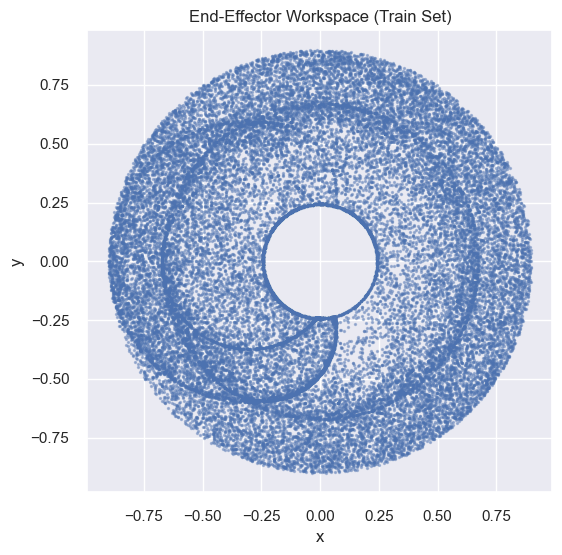

In [63]:
plt.figure(figsize=(6,6))
plt.scatter(train_df['x'], train_df['y'], s=2, alpha=0.4)
plt.title("End-Effector Workspace (Train Set)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()


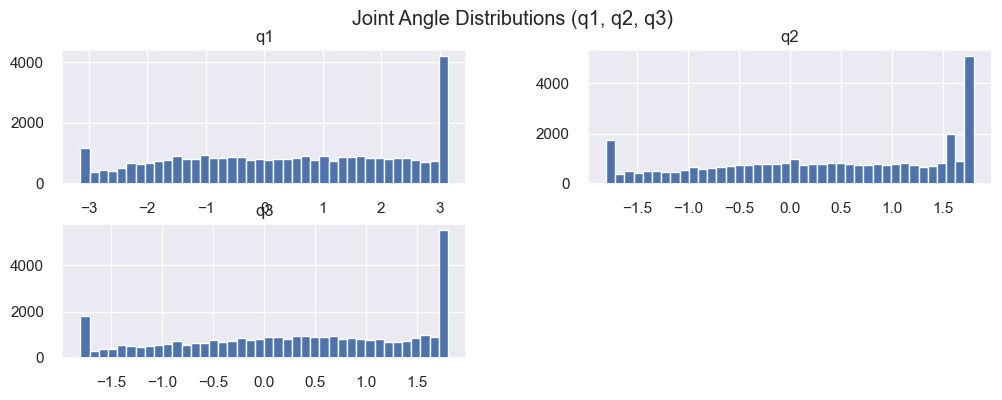

In [64]:
train_df[['q1','q2','q3']].hist(bins=40, figsize=(12,4))
plt.suptitle("Joint Angle Distributions (q1, q2, q3)")
plt.show()


### Interpretation of Joint Angle Distributions

Each histogram shows how frequently each joint angle value appears in the training
dataset. The x-axis represents the joint angle in radians, while the y-axis shows how
many samples fall within each bin.

- For q1, the range is approximately [-3.14, +3.14], which corresponds to its physical
  limits [-π, +π].
- For q2 and q3, the range is approximately [-1.57, +1.57], corresponding to
  [-π/2, +π/2].

The distributions are not uniform. All three joints show strong clustering near their
upper limits (π for q1 and π/2 for q2 and q3). This indicates that the dataset contains
many configurations near joint boundaries, while mid-range angles are less represented.

  - [3.2 Displacement statistics](#32-displacement-statistics)


We analyze how large the workspace displacements (dx, dy) and joint displacements (dq1–dq3) are.
This reveals the “locality” of the dataset.


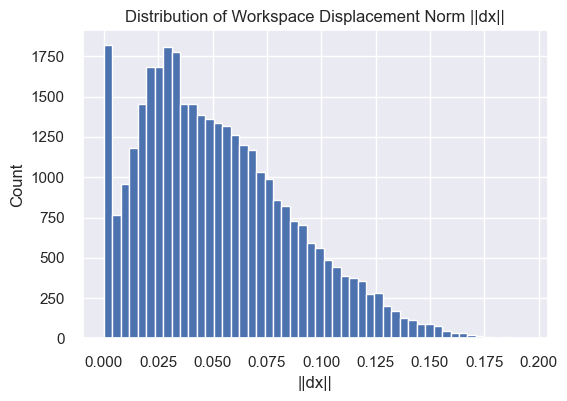

count    35000.000000
mean         0.052466
std          0.034961
min          0.000000
25%          0.025381
50%          0.046861
75%          0.074399
max          0.194523
dtype: float64

In [66]:
dx_norm = np.sqrt(train_df['dx']**2 + train_df['dy']**2)

plt.figure(figsize=(6,4))
plt.hist(dx_norm, bins=50)
plt.title("Distribution of Workspace Displacement Norm ||dx||")
plt.xlabel("||dx||")
plt.ylabel("Count")
plt.show()

dx_norm.describe()


### Distribution of End-Effector Displacement Magnitudes ‖dx‖

This histogram shows the magnitude of the workspace displacement ‖dx‖ for all samples
in the dataset. The distribution is highly skewed toward very small displacements:
most values lie between 0.00 and 0.05, with a long tail extending up to ~0.18.


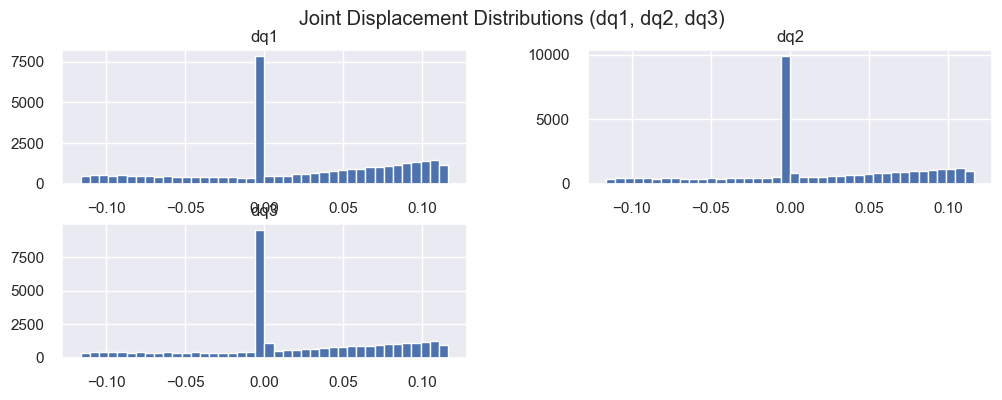

In [67]:
train_df[['dq1','dq2','dq3']].hist(bins=40, figsize=(12,4))
plt.suptitle("Joint Displacement Distributions (dq1, dq2, dq3)")
plt.show()


### Joint Displacement Distributions (dq₁, dq₂, dq₃)

The histograms of the joint displacements (dq) reveal a strong concentration of values
very close to zero for all three joints. This confirms that the dataset is strongly
dominated by extremely small local motions, which is expected for a local inverse
kinematics dataset.


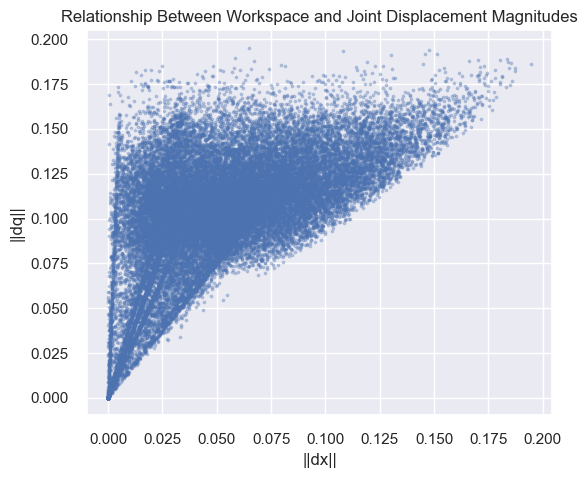

In [68]:
dq_norm = np.sqrt(train_df['dq1']**2 + train_df['dq2']**2 + train_df['dq3']**2)

plt.figure(figsize=(6,5))
plt.scatter(dx_norm, dq_norm, s=3, alpha=0.3)
plt.xlabel("||dx||")
plt.ylabel("||dq||")
plt.title("Relationship Between Workspace and Joint Displacement Magnitudes")
plt.show()


### Relationship Between ‖dx‖ and ‖dq‖

This plot shows how the size of a Cartesian displacement (‖dx‖) relates to the size of
the joint displacement required to produce it (‖dq‖). A few key patterns stand out:

- **Small dx does not always mean small dq.**  
  Depending on the robot’s configuration, even tiny end-effector movements can require
  noticeably larger joint adjustments. This is typical when the arm is close to
  singularities or stretched-out poses.

- **Larger dx generally lead to larger dq, but not in a perfectly linear way.**  
  This shape in the plot reflects the fact that the inverse kinematics depend on
  the current joint angles, so the same dx can correspond to different dq values.

- **The mapping is clearly nonlinear and configuration-dependent.**  
  This helps motivate why simple linear models are not sufficient and why more flexible
  models (like MLPs) tend to perform better.

  - [3.3 Train vs test comparison](#33-train-vs-test-comparison)
We compare feature distributions between train and test splits to ensure there is no major dataset shift.


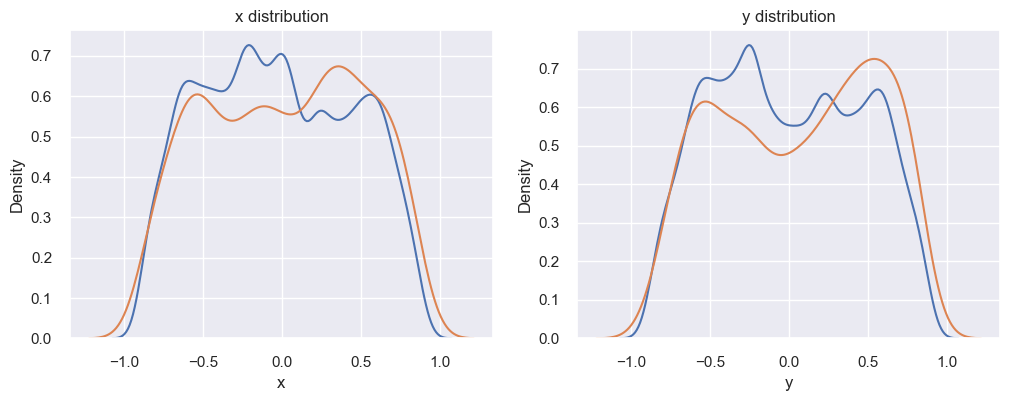

In [71]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.kdeplot(train_df['x'], label='train', ax=ax[0])
sns.kdeplot(test_df['x'], label='test', ax=ax[0])
ax[0].set_title("x distribution")

sns.kdeplot(train_df['y'], label='train', ax=ax[1])
sns.kdeplot(test_df['y'], label='test', ax=ax[1])
ax[1].set_title("y distribution")

plt.show()


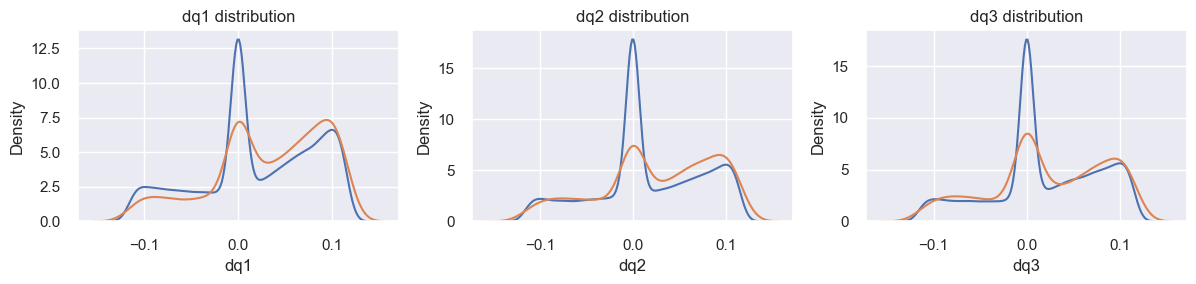

In [72]:
fig, axes = plt.subplots(1,3, figsize=(12,3))

for i, dq in enumerate(["dq1","dq2","dq3"]):
    sns.kdeplot(train_df[dq], ax=axes[i], label='train')
    sns.kdeplot(test_df[dq], ax=axes[i], label='test')
    axes[i].set_title(f"{dq} distribution")

plt.tight_layout()
plt.show()


### Train–Test Distribution Comparison

To ensure that the learning task is well-posed, we compare the distributions of the
train and test sets for both the workspace coordinates (x, y) and the joint
displacements dq. The two distributions overlap almost perfectly, which confirms that
the dataset split does not introduce any covariate shift. In practical terms, the
model is evaluated on data drawn from the same underlying distribution that it sees
during training, making the test performance meaningful and representative.


[4. Data preprocessing – Reacher3](#4-data-preprocessing--reacher3)


Before training the inverse model, we must prepare the dataset:

- Select feature and target columns  
- Split into train / validation / test  
- Standarize the input space



In [73]:
# Feature columns (inputs)
X_cols = ['x','y','q1','q2','q3','dx','dy']

# Target columns (outputs)
y_cols = ['dq1','dq2','dq3']

X_train = train_df[X_cols].values
y_train = train_df[y_cols].values

X_test  = test_df[X_cols].values
y_test  = test_df[y_cols].values

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((35000, 7), (35000, 3), (2000, 7), (2000, 3))

- [4.2 Train/Val Split – Reacher3](#42-split--reacher3)

We create an 80/20 split from the training set.
The validation set is used for early stopping, hyperparameter tuning, and model selection.


In [74]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.20,
    random_state=42,
    shuffle=True
)

X_train.shape, X_val.shape


((28000, 7), (7000, 7))

- [4.3 Scaling – Reacher3](#43-scaling--reacher3)

Because inputs have very different numerical ranges (e.g., angles in radians vs workspace in meters),
we normalize all input features.

This is essential for neural network training and beneficial for linear models.

We use `StandardScaler` for the data


In [75]:
from sklearn.preprocessing import StandardScaler

# Create scalers
X_scaler = StandardScaler()
y_scaler = StandardScaler()

# Fit only on training set (NEVER on validation/test)
X_scaler.fit(X_train)
y_scaler.fit(y_train)

# Transform splits
X_train_s = X_scaler.transform(X_train)
X_val_s   = X_scaler.transform(X_val)
X_test_s  = X_scaler.transform(X_test)

# Scale target (recommended for neural nets)
y_train_s = y_scaler.transform(y_train)
y_val_s   = y_scaler.transform(y_val)
y_test_s  = y_scaler.transform(y_test)


In [76]:
X_train_s[:2], y_train_s[:2]


(array([[ 1.23035885,  0.55352139,  0.54773357, -1.18199815, -1.26583843,
         -0.17926498, -1.02758082],
        [ 0.68689851,  0.21893777, -0.99942776,  1.29408299,  0.88144343,
         -0.33813265,  0.69718643]]),
 array([[-1.0699408 , -0.29038678, -2.02901446],
        [ 1.35450998, -0.29038678, -0.03148957]]))

In [78]:
print("Train set:", X_train_s.shape, y_train_s.shape)
print("Val set:  ", X_val_s.shape,   y_val_s.shape)
print("Test set: ", X_test_s.shape,  y_test_s.shape)


Train set: (28000, 7) (28000, 3)
Val set:   (7000, 7) (7000, 3)
Test set:  (2000, 7) (2000, 3)


[5. Classical models – Reacher3](#5-classical-models--reacher3)


In this section we train four classical ML models:

1. **Linear Regression** (baseline)  
2. **Ridge Regression** (L2-regularized linear)  
3. **Random Forest Regressor** (nonlinear, bagging)  
4. **XGBoost Regressor** (nonlinear, boosting)

For each model we:

- fit on `(X_train_s, y_train)`
- evaluate on train & validation
- visualize **true vs predicted** joint displacements \((dq_1, dq_2, dq_3)\)
- finally evaluate the best model on the test set.


In [130]:
#helper functions for evaluation and plotting
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

def evaluate_regressor(model, X_tr, y_tr, X_val, y_val, name="model"):
    """
    Compute MSE, MAE, and R^2 on train and validation sets.
    """
    y_tr_pred  = model.predict(X_tr)
    y_val_pred = model.predict(X_val)

    metrics = {}
    for split, y_true, y_pred in [
        ("train", y_tr, y_tr_pred),
        ("val",   y_val, y_val_pred),
    ]:
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2  = r2_score(y_true, y_pred)
        metrics[split] = {"mse": mse, "mae": mae, "r2": r2}

    print(f"=== {name} ===")
    for split in ["train", "val"]:
        m = metrics[split]
        print(f"{split.upper()}: MSE={m['mse']:.4e}, MAE={m['mae']:.4e}, R2={m['r2']:.4f}")
    print()
    return metrics


def plot_true_vs_pred(y_true, y_pred, model_name="model", dq_names=('dq1','dq2','dq3')):
    """
    Scatter plots of true vs predicted dq_i for i=1..3.
    Points on the diagonal = perfect predictions.
    """
    fig, axes = plt.subplots(1, len(dq_names), figsize=(5*len(dq_names), 4))

    if len(dq_names) == 1:
        axes = [axes]

    for i, dq_name in enumerate(dq_names):
        ax = axes[i]
        ax.scatter(y_true[:, i], y_pred[:, i], s=3, alpha=0.3)
        mn = min(y_true[:, i].min(), y_pred[:, i].min())
        mx = max(y_true[:, i].max(), y_pred[:, i].max())
        ax.plot([mn, mx], [mn, mx], 'k--', linewidth=1)
        ax.set_xlabel(f"True {dq_name}")
        ax.set_ylabel(f"Pred {dq_name}")
        ax.set_title(f"{model_name}: {dq_name}")

    plt.tight_layout()
    plt.show()


=== LinearRegression ===
TRAIN: MSE=3.4651e-03, MAE=4.8354e-02, R2=0.0284
VAL: MSE=3.4201e-03, MAE=4.8085e-02, R2=0.0314



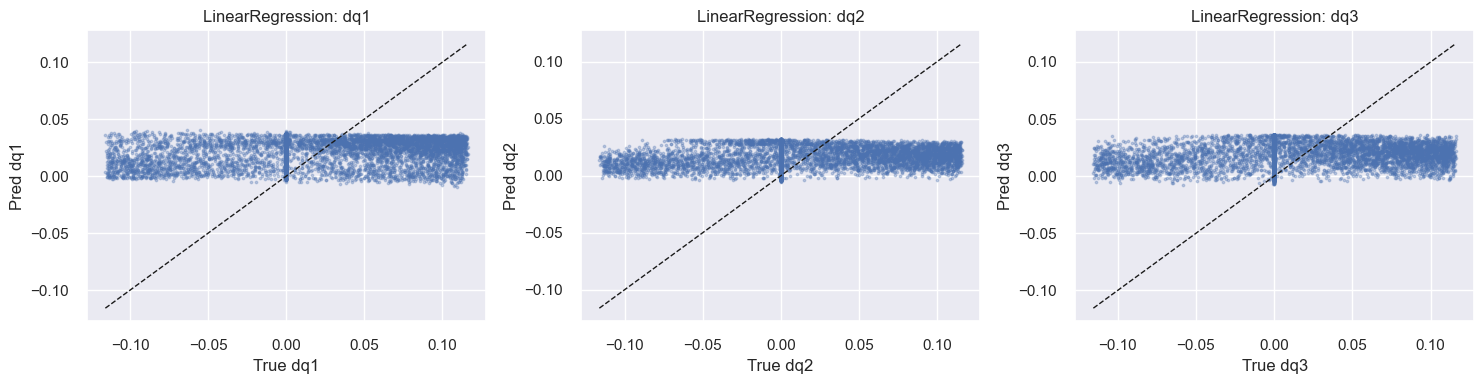

In [131]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_s, y_train)

linreg_metrics = evaluate_regressor(
    linreg,
    X_train_s, y_train,
    X_val_s,   y_val,
    name="LinearRegression"
)

y_val_pred_lin = linreg.predict(X_val_s)
plot_true_vs_pred(y_val, y_val_pred_lin, model_name="LinearRegression")


Linear regression struggles quite a bit with this task, and the plots make it very clear why. The true–predicted scatter looks more like a flat cloud than a diagonal line, meaning the model cannot capture how the joint displacements actually change in different configurations. Since linear regression can only model a single global straight-line relationship, it ends up predicting values clustered around zero for almost everything. This works “okay” for the many tiny dq samples in the dataset but completely fails to represent the meaningful structure of the inverse mapping. In short, the model is far too simple for the nonlinear relationship between (x, y, q, dx, dy) and dq, and the plots reflect this limitation directly.


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best RF params: {'max_depth': None, 'max_features': 0.7, 'min_samples_leaf': 1, 'n_estimators': 200}
Best RF CV score (neg MSE): -0.0012166568685604924
=== RandomForest (best) ===
TRAIN: MSE=1.5445e-04, MAE=8.8100e-03, R2=0.9556
VAL: MSE=1.1206e-03, MAE=2.3835e-02, R2=0.6750



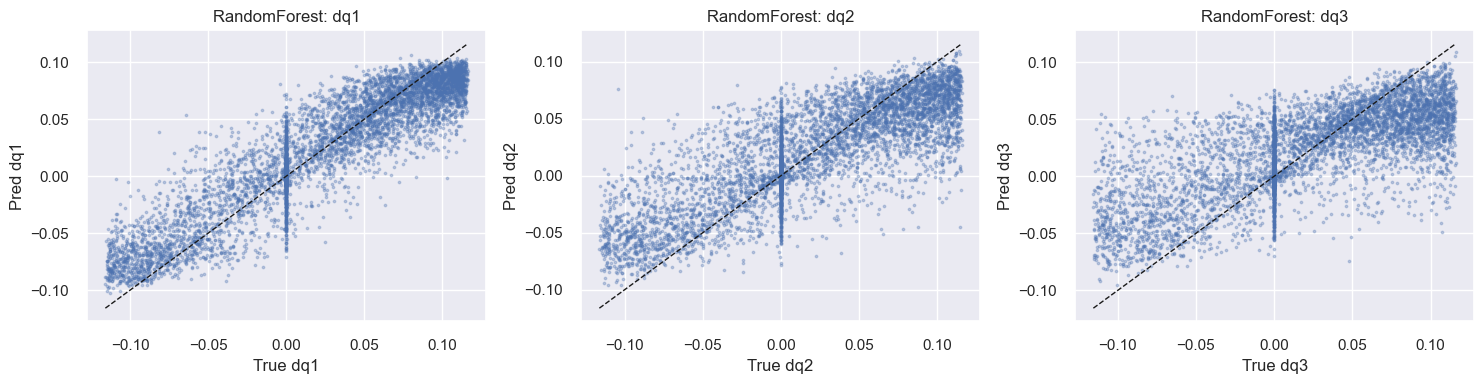

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [8, 12, None],   
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", 0.7] 
}


rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    scoring="neg_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_s, y_train)

print("Best RF params:", rf_grid.best_params_)
print("Best RF CV score (neg MSE):", rf_grid.best_score_)

best_rf = rf_grid.best_estimator_

rf_metrics = evaluate_regressor(
    best_rf,
    X_train_s, y_train,
    X_val_s,   y_val,
    name="RandomForest (best)"
)

y_val_pred_rf = best_rf.predict(X_val_s)
plot_true_vs_pred(y_val, y_val_pred_rf, model_name="RandomForest")


The Random Forest model provides a reasonable nonlinear baseline, but it quickly reaches
its limits on this task. We are able to see that after hyperparameter search model choses max depth and possibly overfit on the model given that R^2 score is around 50% higher in training set. This is noticeably better than the linear models.


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best XGB params: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 6, 'estimator__min_child_weight': 5, 'estimator__n_estimators': 300}
Best XGB CV score (neg MSE): -0.00131289446451807
=== XGBoost (best) ===
TRAIN: MSE=7.6518e-04, MAE=2.0447e-02, R2=0.7801
VAL: MSE=1.2462e-03, MAE=2.5936e-02, R2=0.6385



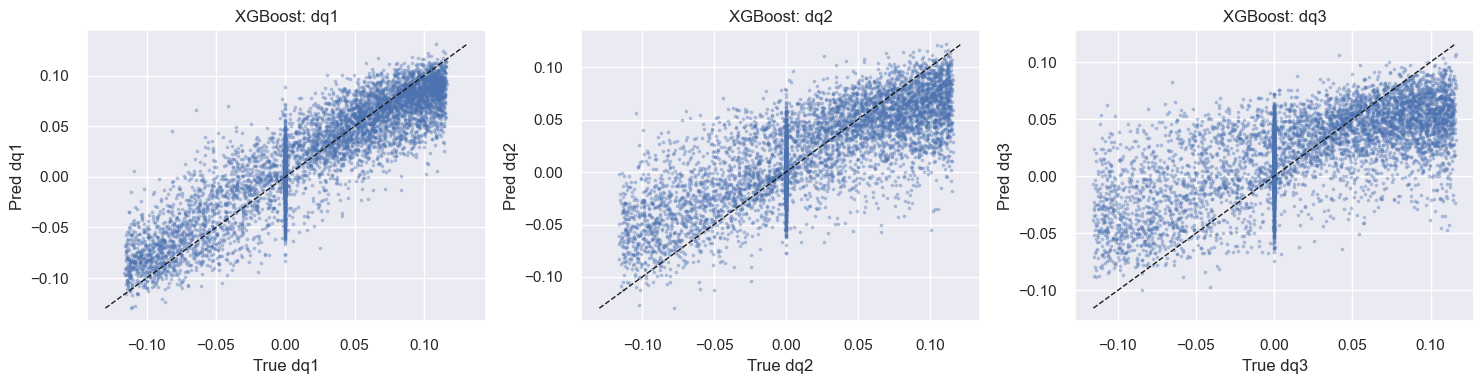

In [133]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

xgb_base = XGBRegressor(
    objective="reg:squarederror",
    n_jobs=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

xgb_multi = MultiOutputRegressor(xgb_base)

xgb_param_grid = {
    "estimator__n_estimators": [100, 200, 300],
    "estimator__max_depth": [4, 5, 6],
    "estimator__learning_rate": [0.05, 0.1],
    "estimator__min_child_weight": [1, 5]
}

xgb_grid = GridSearchCV(
    estimator=xgb_multi,
    param_grid=xgb_param_grid,
    scoring="neg_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train_s, y_train)

print("Best XGB params:", xgb_grid.best_params_)
print("Best XGB CV score (neg MSE):", xgb_grid.best_score_)

best_xgb = xgb_grid.best_estimator_

xgb_metrics = evaluate_regressor(
    best_xgb,
    X_train_s, y_train,
    X_val_s,   y_val,
    name="XGBoost (best)"
)

y_val_pred_xgb = best_xgb.predict(X_val_s)
plot_true_vs_pred(y_val, y_val_pred_xgb, model_name="XGBoost")


XGBoost reaches a validation R² of around 0.64, which is a clear improvement over the earlier setup. It captures the nonlinear trends reasonably well, but it still ends up slightly behind the best Random Forest model. Boosted trees smooth things out a bit too much for this task, especially for the larger dq values, so while XGBoost is a solid classical model, it doesn’t fully match the flexibility needed for the more complex parts of the mapping.


In [139]:
linreg_metrics = evaluate_regressor(
    linreg,
    X_train_s, y_train,
    X_val_s,   y_val,
    name="LinearRegression"
)

rf_metrics = evaluate_regressor(
    best_rf,
    X_train_s, y_train,
    X_val_s,   y_val,
    name="RandomForest (best)"
)

xgb_metrics = evaluate_regressor(
    best_xgb,
    X_train_s, y_train,
    X_val_s,   y_val,
    name="XGBoost (best)"
)

=== LinearRegression ===
TRAIN: MSE=3.4651e-03, MAE=4.8354e-02, R2=0.0284
VAL: MSE=3.4201e-03, MAE=4.8085e-02, R2=0.0314

=== RandomForest (best) ===
TRAIN: MSE=1.5445e-04, MAE=8.8100e-03, R2=0.9556
VAL: MSE=1.1206e-03, MAE=2.3835e-02, R2=0.6750

=== XGBoost (best) ===
TRAIN: MSE=7.6518e-04, MAE=2.0447e-02, R2=0.7801
VAL: MSE=1.2462e-03, MAE=2.5936e-02, R2=0.6385



In [140]:
models = {
    "Linear": linreg,
    "RandomForest": best_rf,
    "XGBoost": best_xgb,
}

dq_norm_val = np.linalg.norm(y_val, axis=1)

bins = [0.0, 0.01, 0.03, np.inf]
bin_labels = ["very_small (0-0.01)", "small (0.01-0.03)", "medium+ (>0.03)"]

dq_bins = pd.cut(dq_norm_val, bins=bins, labels=bin_labels, include_lowest=True)

def mse_by_bin(y_true, y_pred, bins_series):
    results = {}
    for label in bin_labels:
        mask = (bins_series == label)
        if mask.any():
            results[label] = mean_squared_error(y_true[mask], y_pred[mask])
        else:
            results[label] = np.nan
    return results

bin_rows = []
for name, model in models.items():
    y_val_pred = model.predict(X_val_s)
    per_bin = mse_by_bin(y_val, y_val_pred, dq_bins)
    per_bin["Model"] = name
    bin_rows.append(per_bin)

bins_df = pd.DataFrame(bin_rows).set_index("Model")
bins_df


very_small (0-0.01)  small (0.01-0.03)  medium+ (>0.03)
Model                                                                
Linear                   0.000661           0.000699         0.003582
RandomForest             0.000015           0.000119         0.001183
XGBoost                  0.000044           0.000164         0.001314

[6. Neural networks – Reacher3](#6-neural-networks--reacher3)

Classical linear and tree-based models show limitations:

- Linear fail to capture the nonlinear coupling of joint angles.
- Random Forest and XGBoost learn the structure but struggle with the extremely dense region near zero.
- None of them model the smooth Jacobian-like structure of dq as a function of (q, x, dx).

A **neural network** (multi-layer perceptron) is a natural choice because:

- It can approximate smooth nonlinear mappings.
- It handles multi-output regression well.
- It learns a continuous function needed for robot control.

We will train a small MLP on normalized inputs and outputs.


In [ ]:
def evaluate_model(model, X_val_s, y_val_s, y_val, y_scaler, name="Model"):
    y_val_pred_s = model.predict(X_val_s)
    y_val_pred = y_scaler.inverse_transform(y_val_pred_s)

    mse = mean_squared_error(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)
    r2  = r2_score(y_val, y_val_pred)

    print(f"=== {name} (Validation) ===")
    print(f"MSE: {mse:.5e}")
    print(f"MAE: {mae:.5e}")
    print(f"R2 : {r2:.4f}")

    return y_val_pred, mse, mae, r2


Epoch 1/40
110/110 - 1s - loss: 0.7335 - mae: 0.6892 - val_loss: 0.6212 - val_mae: 0.6271 - 763ms/epoch - 7ms/step
Epoch 2/40
110/110 - 0s - loss: 0.5978 - mae: 0.6135 - val_loss: 0.5771 - val_mae: 0.5986 - 235ms/epoch - 2ms/step
Epoch 3/40
110/110 - 0s - loss: 0.5582 - mae: 0.5869 - val_loss: 0.5412 - val_mae: 0.5751 - 248ms/epoch - 2ms/step
Epoch 4/40
110/110 - 0s - loss: 0.5237 - mae: 0.5635 - val_loss: 0.5086 - val_mae: 0.5535 - 235ms/epoch - 2ms/step
Epoch 5/40
110/110 - 0s - loss: 0.4932 - mae: 0.5430 - val_loss: 0.4821 - val_mae: 0.5356 - 244ms/epoch - 2ms/step
Epoch 6/40
110/110 - 0s - loss: 0.4661 - mae: 0.5256 - val_loss: 0.4609 - val_mae: 0.5226 - 267ms/epoch - 2ms/step
Epoch 7/40
110/110 - 0s - loss: 0.4468 - mae: 0.5126 - val_loss: 0.4435 - val_mae: 0.5090 - 250ms/epoch - 2ms/step
Epoch 8/40
110/110 - 0s - loss: 0.4318 - mae: 0.5024 - val_loss: 0.4292 - val_mae: 0.4996 - 268ms/epoch - 2ms/step
Epoch 9/40
110/110 - 0s - loss: 0.4192 - mae: 0.4937 - val_loss: 0.4243 - val_ma

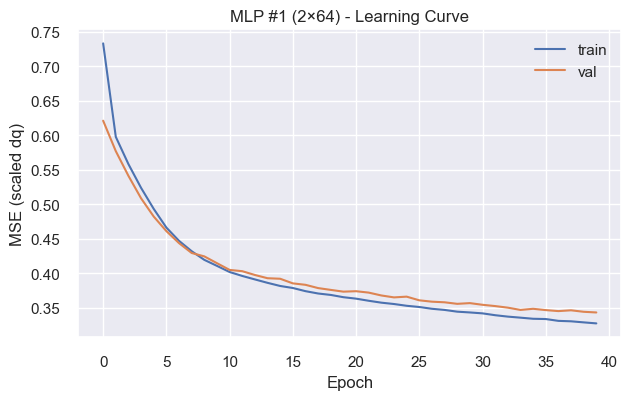

219/219 [==============================] - 0s 1ms/step
=== MLP #1 (2×64) (Validation) ===
MSE: 1.19186e-03
MAE: 2.58958e-02
R2 : 0.6538


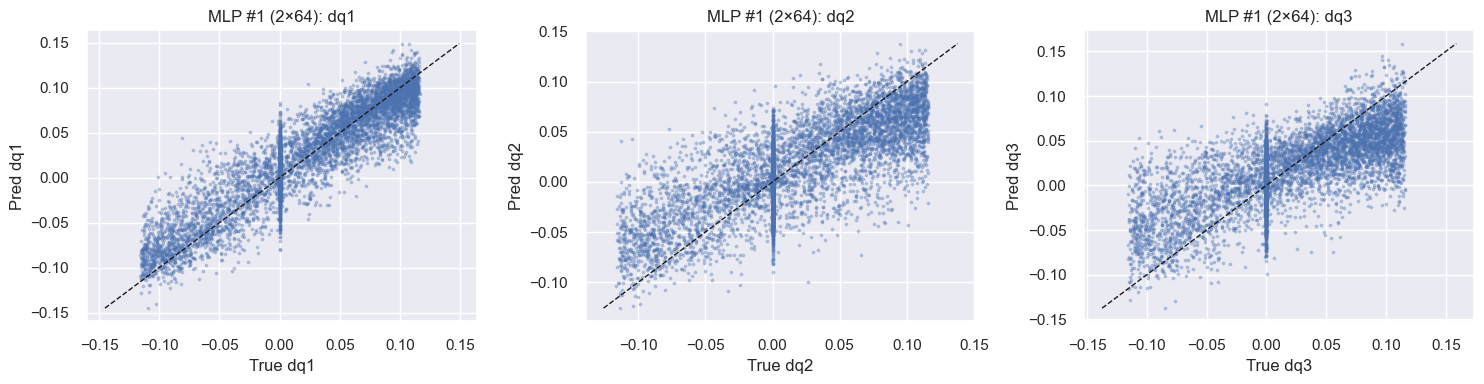

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

tf.random.set_seed(42)

mlp1 = models.Sequential([
    layers.Input(shape=(X_train_s.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(3, activation="linear"),
])

mlp1.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["mae"]
)

history1 = mlp1.fit(
    X_train_s, y_train_s,
    validation_data=(X_val_s, y_val_s),
    epochs=40,
    batch_size=256,
    verbose=2
)

plt.figure(figsize=(7,4))
plt.plot(history1.history["loss"], label="train")
plt.plot(history1.history["val_loss"], label="val")
plt.title("MLP #1 (2×64) - Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled dq)")
plt.legend()
plt.show()

y_val_pred1, mse1, mae1, r21 = evaluate_model(
    mlp1, X_val_s, y_val_s, y_val, y_scaler, name="MLP #1 (2×64)"
)
plot_true_vs_pred(y_val, y_val_pred1, model_name="MLP #1 (2×64)")


Epoch 1/40
110/110 - 1s - loss: 0.7380 - mae: 0.6929 - val_loss: 0.6297 - val_mae: 0.6341 - 686ms/epoch - 6ms/step
Epoch 2/40
110/110 - 0s - loss: 0.6059 - mae: 0.6199 - val_loss: 0.5859 - val_mae: 0.6050 - 256ms/epoch - 2ms/step
Epoch 3/40
110/110 - 0s - loss: 0.5675 - mae: 0.5943 - val_loss: 0.5532 - val_mae: 0.5839 - 242ms/epoch - 2ms/step
Epoch 4/40
110/110 - 0s - loss: 0.5359 - mae: 0.5732 - val_loss: 0.5220 - val_mae: 0.5642 - 262ms/epoch - 2ms/step
Epoch 5/40
110/110 - 0s - loss: 0.5075 - mae: 0.5547 - val_loss: 0.4961 - val_mae: 0.5474 - 247ms/epoch - 2ms/step
Epoch 6/40
110/110 - 0s - loss: 0.4811 - mae: 0.5373 - val_loss: 0.4744 - val_mae: 0.5337 - 252ms/epoch - 2ms/step
Epoch 7/40
110/110 - 0s - loss: 0.4577 - mae: 0.5216 - val_loss: 0.4484 - val_mae: 0.5158 - 254ms/epoch - 2ms/step
Epoch 8/40
110/110 - 0s - loss: 0.4380 - mae: 0.5085 - val_loss: 0.4307 - val_mae: 0.5040 - 238ms/epoch - 2ms/step
Epoch 9/40
110/110 - 0s - loss: 0.4201 - mae: 0.4964 - val_loss: 0.4200 - val_ma

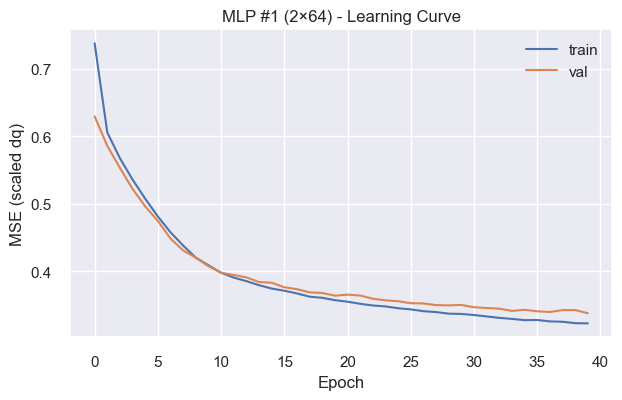

219/219 [==============================] - 0s 1ms/step
=== MLP #1 (2×64) (Validation) ===
MSE: 1.17364e-03
MAE: 2.56053e-02
R2 : 0.6591


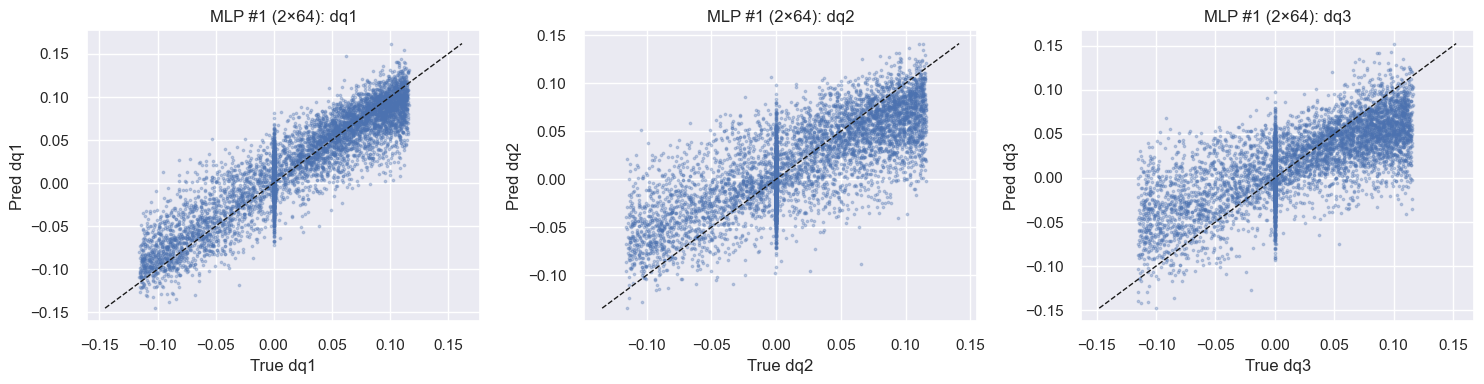

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

tf.random.set_seed(42)

mlp1 = models.Sequential([
    layers.Input(shape=(X_train_s.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(3, activation="linear"),
])

mlp1.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["mae"]
)

history1 = mlp1.fit(
    X_train_s, y_train_s,
    validation_data=(X_val_s, y_val_s),
    epochs=40,
    batch_size=256,
    verbose=2
)

# Learning curve
plt.figure(figsize=(7,4))
plt.plot(history1.history["loss"], label="train")
plt.plot(history1.history["val_loss"], label="val")
plt.title("MLP #1 (2×64) - Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled dq)")
plt.legend()
plt.show()

y_val_pred1, mse1, mae1, r21 = evaluate_model(
    mlp1, X_val_s, y_val_s, y_val, y_scaler, name="MLP #1 (2×64)"
)
plot_true_vs_pred(y_val, y_val_pred1, model_name="MLP #1 (2×64)")


Epoch 1/40
110/110 - 2s - loss: 0.7046 - mae: 0.6740 - val_loss: 0.5886 - val_mae: 0.6089 - 2s/epoch - 14ms/step
Epoch 2/40
110/110 - 0s - loss: 0.5550 - mae: 0.5874 - val_loss: 0.5293 - val_mae: 0.5651 - 339ms/epoch - 3ms/step
Epoch 3/40
110/110 - 0s - loss: 0.4931 - mae: 0.5458 - val_loss: 0.4692 - val_mae: 0.5297 - 412ms/epoch - 4ms/step
Epoch 4/40
110/110 - 0s - loss: 0.4489 - mae: 0.5166 - val_loss: 0.4369 - val_mae: 0.5066 - 412ms/epoch - 4ms/step
Epoch 5/40
110/110 - 0s - loss: 0.4215 - mae: 0.4974 - val_loss: 0.4145 - val_mae: 0.4910 - 385ms/epoch - 3ms/step
Epoch 6/40
110/110 - 0s - loss: 0.4035 - mae: 0.4842 - val_loss: 0.4099 - val_mae: 0.4899 - 210ms/epoch - 2ms/step
Epoch 7/40
110/110 - 0s - loss: 0.3950 - mae: 0.4776 - val_loss: 0.3974 - val_mae: 0.4815 - 217ms/epoch - 2ms/step
Epoch 8/40
110/110 - 0s - loss: 0.3846 - mae: 0.4702 - val_loss: 0.3870 - val_mae: 0.4703 - 265ms/epoch - 2ms/step
Epoch 9/40
110/110 - 0s - loss: 0.3743 - mae: 0.4625 - val_loss: 0.3780 - val_mae:

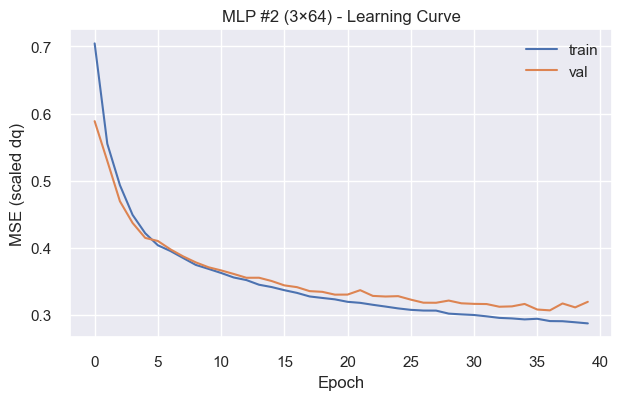

219/219 [==============================] - 0s 1ms/step
=== MLP #2 (3×64) (Validation) ===
MSE: 1.11057e-03
MAE: 2.46770e-02
R2 : 0.6776


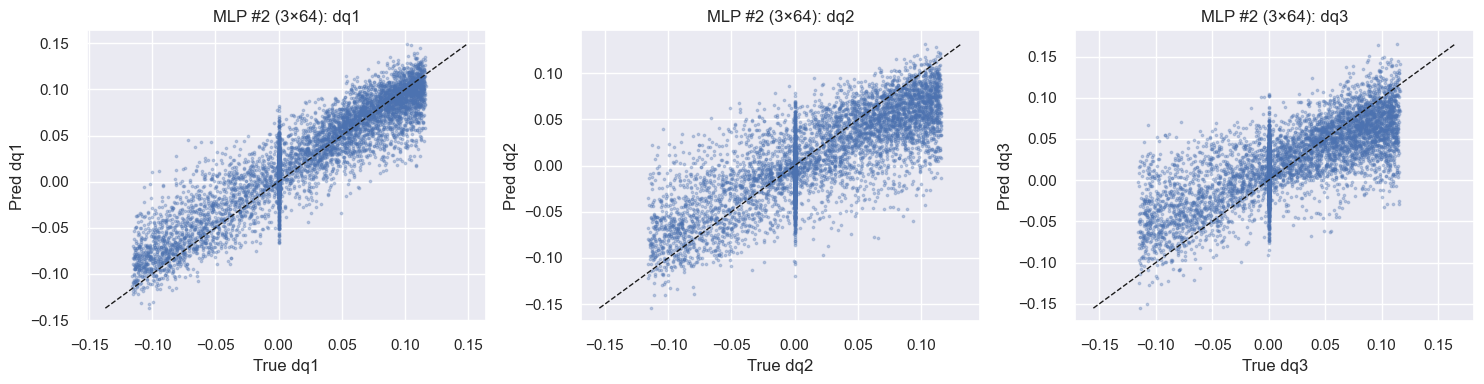

In [ ]:
mlp2 = models.Sequential([
    layers.Input(shape=(X_train_s.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(3, activation="linear"),
])

mlp2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["mae"]
)

history2 = mlp2.fit(
    X_train_s, y_train_s,
    validation_data=(X_val_s, y_val_s),
    epochs=40,
    batch_size=256,
    verbose=2
)

plt.figure(figsize=(7,4))
plt.plot(history2.history["loss"], label="train")
plt.plot(history2.history["val_loss"], label="val")
plt.title("MLP #2 (3×64) - Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled dq)")
plt.legend()
plt.show()

y_val_pred2, mse2, mae2, r22 = evaluate_model(
    mlp2, X_val_s, y_val_s, y_val, y_scaler, name="MLP #2 (3×64)"
)
plot_true_vs_pred(y_val, y_val_pred2, model_name="MLP #2 (3×64)")


Epoch 1/40
110/110 - 2s - loss: 0.6369 - mae: 0.6359 - val_loss: 0.5410 - val_mae: 0.5779 - 2s/epoch - 16ms/step
Epoch 2/40
110/110 - 0s - loss: 0.4826 - mae: 0.5385 - val_loss: 0.4480 - val_mae: 0.5127 - 393ms/epoch - 4ms/step
Epoch 3/40
110/110 - 0s - loss: 0.4190 - mae: 0.4950 - val_loss: 0.4004 - val_mae: 0.4781 - 448ms/epoch - 4ms/step
Epoch 4/40
110/110 - 0s - loss: 0.3923 - mae: 0.4750 - val_loss: 0.3876 - val_mae: 0.4700 - 428ms/epoch - 4ms/step
Epoch 5/40
110/110 - 0s - loss: 0.3768 - mae: 0.4633 - val_loss: 0.3760 - val_mae: 0.4602 - 428ms/epoch - 4ms/step
Epoch 6/40
110/110 - 0s - loss: 0.3643 - mae: 0.4538 - val_loss: 0.3656 - val_mae: 0.4539 - 421ms/epoch - 4ms/step
Epoch 7/40
110/110 - 0s - loss: 0.3523 - mae: 0.4455 - val_loss: 0.3543 - val_mae: 0.4463 - 435ms/epoch - 4ms/step
Epoch 8/40
110/110 - 1s - loss: 0.3422 - mae: 0.4369 - val_loss: 0.3480 - val_mae: 0.4390 - 537ms/epoch - 5ms/step
Epoch 9/40
110/110 - 0s - loss: 0.3309 - mae: 0.4283 - val_loss: 0.3406 - val_mae:

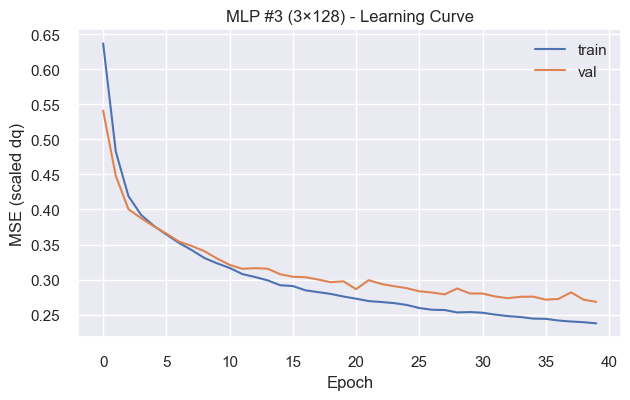

219/219 [==============================] - 0s 2ms/step
=== MLP #3 (3×128) (Validation) ===
MSE: 9.32223e-04
MAE: 2.16882e-02
R2 : 0.7291


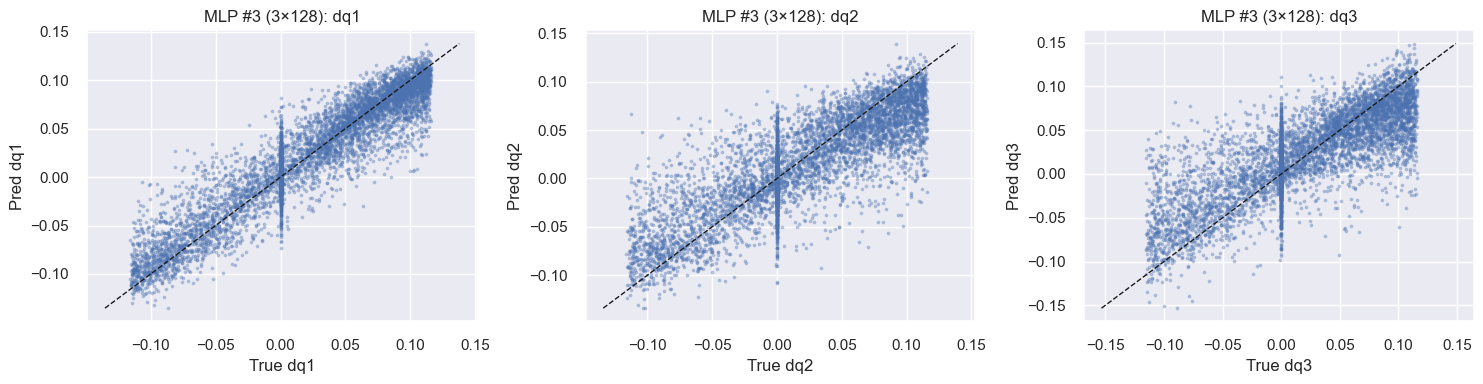

In [ ]:
mlp3 = models.Sequential([
    layers.Input(shape=(X_train_s.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="linear"),
])

mlp3.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["mae"]
)

history3 = mlp3.fit(
    X_train_s, y_train_s,
    validation_data=(X_val_s, y_val_s),
    epochs=40,
    batch_size=256,
    verbose=2
)

plt.figure(figsize=(7,4))
plt.plot(history3.history["loss"], label="train")
plt.plot(history3.history["val_loss"], label="val")
plt.title("MLP #3 (3×128) - Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled dq)")
plt.legend()
plt.show()

y_val_pred3, mse3, mae3, r23 = evaluate_model(
    mlp3, X_val_s, y_val_s, y_val, y_scaler, name="MLP #3 (3×128)"
)
plot_true_vs_pred(y_val, y_val_pred3, model_name="MLP #3 (3×128)")


In [104]:
print("Validation comparison:")
print(f"MLP #1 (2×64):  MSE={mse1:.5e}, MAE={mae1:.5e}, R2={r21:.4f}")
print(f"MLP #2 (3×64):  MSE={mse2:.5e}, MAE={mae2:.5e}, R2={r22:.4f}")
print(f"MLP #3 (3×128): MSE={mse3:.5e}, MAE={mae3:.5e}, R2={r23:.4f}")


Validation comparison:
MLP #1 (2×64):  MSE=1.17364e-03, MAE=2.56053e-02, R2=0.6591
MLP #2 (3×64):  MSE=1.11057e-03, MAE=2.46770e-02, R2=0.6776
MLP #3 (3×128): MSE=9.32223e-04, MAE=2.16882e-02, R2=0.7291


We consistently observed that dq₁ is much easier for the neural networks to predict
than dq₂ and dq₃. This makes sense when looking at the geometry of the robot: the base
joint (q₁) mainly rotates the entire arm, so its effect on the end-effector is smooth,
large, and fairly predictable. In contrast, q₂ and q₃ shape the arm and behave much
more nonlinearly. Their influence depends strongly on the robot’s current posture, and
the same workspace displacement can require very different dq₂/dq₃ adjustments
depending on configuration. As a result, dq₂ and dq₃ naturally show more spread and
more ambiguity in the dataset, making them harder for the MLPs to approximate.


- [6.1 Regularization & improved training](#61-regularization--improved-training)

The plain MLPs can still:

- slightly overfit (train loss < val loss),
- be sensitive to initialization / learning rate,
- and not generalize perfectly across the workspace.

We now improve the model by adding:

- **Dropout** → reduces overfitting by randomly dropping units  
- **Batch Normalization** → stabilizes training and allows deeper architectures  
- **Early Stopping** → stops training when validation loss no longer improves  
- **Momentum (SGD + momentum)** → alternative optimizer that can sometimes converge smoother than Adam

We start from a strong base architecture (3 hidden layers × 128 units) and progressively add these techniques.


Epoch 1/200
110/110 - 2s - loss: 0.7247 - mae: 0.6842 - val_loss: 0.5968 - val_mae: 0.6162 - 2s/epoch - 14ms/step
Epoch 2/200
110/110 - 0s - loss: 0.6198 - mae: 0.6260 - val_loss: 0.5372 - val_mae: 0.5747 - 494ms/epoch - 4ms/step
Epoch 3/200
110/110 - 0s - loss: 0.5714 - mae: 0.5959 - val_loss: 0.4900 - val_mae: 0.5452 - 433ms/epoch - 4ms/step
Epoch 4/200
110/110 - 0s - loss: 0.5373 - mae: 0.5743 - val_loss: 0.4575 - val_mae: 0.5238 - 421ms/epoch - 4ms/step
Epoch 5/200
110/110 - 0s - loss: 0.5136 - mae: 0.5601 - val_loss: 0.4351 - val_mae: 0.5074 - 401ms/epoch - 4ms/step
Epoch 6/200
110/110 - 0s - loss: 0.4952 - mae: 0.5481 - val_loss: 0.4192 - val_mae: 0.4973 - 363ms/epoch - 3ms/step
Epoch 7/200
110/110 - 0s - loss: 0.4786 - mae: 0.5368 - val_loss: 0.4060 - val_mae: 0.4878 - 420ms/epoch - 4ms/step
Epoch 8/200
110/110 - 0s - loss: 0.4670 - mae: 0.5285 - val_loss: 0.3957 - val_mae: 0.4798 - 467ms/epoch - 4ms/step
Epoch 9/200
110/110 - 0s - loss: 0.4576 - mae: 0.5222 - val_loss: 0.3884 -

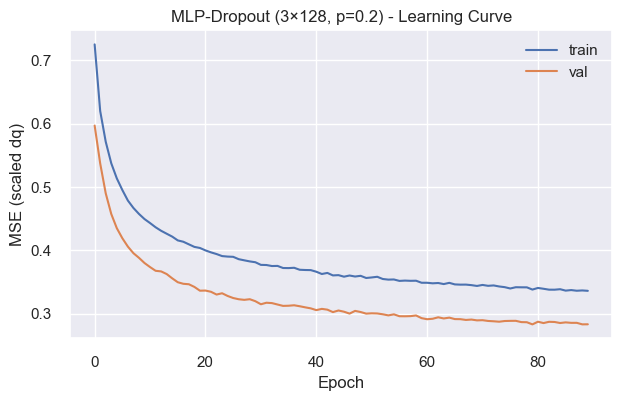

219/219 [==============================] - 0s 1ms/step
=== MLP-Dropout (3×128, p=0.2) (Validation) ===
MSE: 9.85429e-04
MAE: 2.26071e-02
R2 : 0.7138


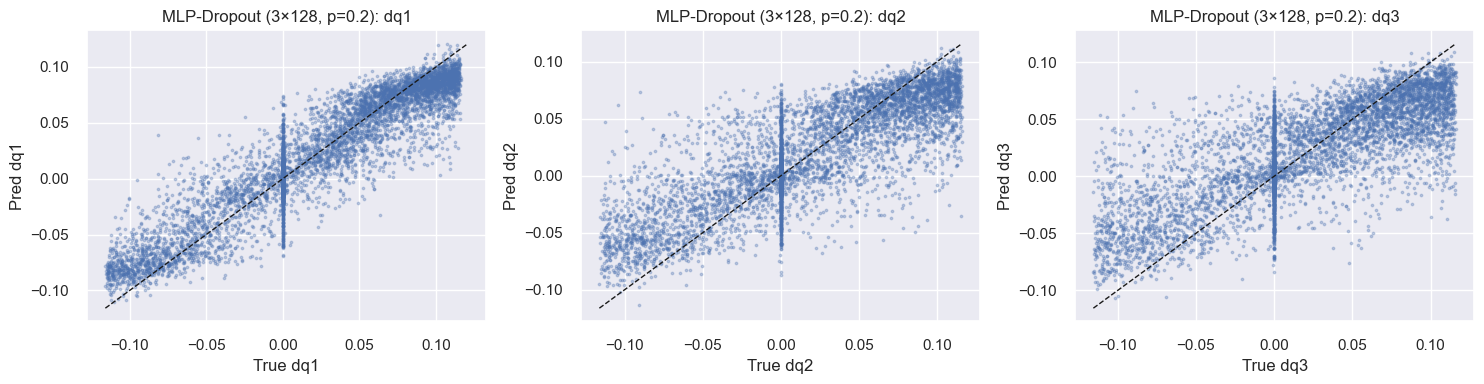

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

mlp_drop = models.Sequential([
    layers.Input(shape=(X_train_s.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(3, activation="linear"),
])

mlp_drop.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["mae"]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history_drop = mlp_drop.fit(
    X_train_s, y_train_s,
    validation_data=(X_val_s, y_val_s),
    epochs=200,            
    batch_size=256,
    callbacks=[early_stop],
    verbose=2
)

plt.figure(figsize=(7,4))
plt.plot(history_drop.history["loss"], label="train")
plt.plot(history_drop.history["val_loss"], label="val")
plt.title("MLP-Dropout (3×128, p=0.2) - Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled dq)")
plt.legend()
plt.show()

y_val_pred_drop, mse_drop, mae_drop, r2_drop = evaluate_model(
    mlp_drop, X_val_s, y_val_s, y_val, y_scaler, name="MLP-Dropout (3×128, p=0.2)"
)
plot_true_vs_pred(y_val, y_val_pred_drop, model_name="MLP-Dropout (3×128, p=0.2)")


Epoch 1/200
110/110 - 2s - loss: 0.9941 - mae: 0.7917 - val_loss: 0.7397 - val_mae: 0.6933 - 2s/epoch - 21ms/step
Epoch 2/200
110/110 - 1s - loss: 0.7408 - mae: 0.6849 - val_loss: 0.6066 - val_mae: 0.6191 - 704ms/epoch - 6ms/step
Epoch 3/200
110/110 - 1s - loss: 0.6689 - mae: 0.6508 - val_loss: 0.5417 - val_mae: 0.5797 - 738ms/epoch - 7ms/step
Epoch 4/200
110/110 - 1s - loss: 0.6316 - mae: 0.6304 - val_loss: 0.5068 - val_mae: 0.5569 - 692ms/epoch - 6ms/step
Epoch 5/200
110/110 - 1s - loss: 0.6034 - mae: 0.6146 - val_loss: 0.4876 - val_mae: 0.5449 - 717ms/epoch - 7ms/step
Epoch 6/200
110/110 - 1s - loss: 0.5817 - mae: 0.6039 - val_loss: 0.4701 - val_mae: 0.5327 - 607ms/epoch - 6ms/step
Epoch 7/200
110/110 - 1s - loss: 0.5655 - mae: 0.5936 - val_loss: 0.4585 - val_mae: 0.5268 - 553ms/epoch - 5ms/step
Epoch 8/200
110/110 - 1s - loss: 0.5541 - mae: 0.5863 - val_loss: 0.4421 - val_mae: 0.5144 - 648ms/epoch - 6ms/step
Epoch 9/200
110/110 - 1s - loss: 0.5396 - mae: 0.5778 - val_loss: 0.4328 -

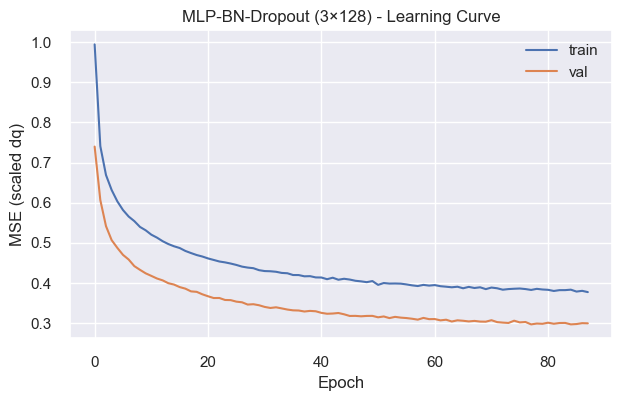

219/219 [==============================] - 0s 2ms/step
=== MLP-BN-Dropout (3×128) (Validation) ===
MSE: 1.03213e-03
MAE: 2.35077e-02
R2 : 0.7002


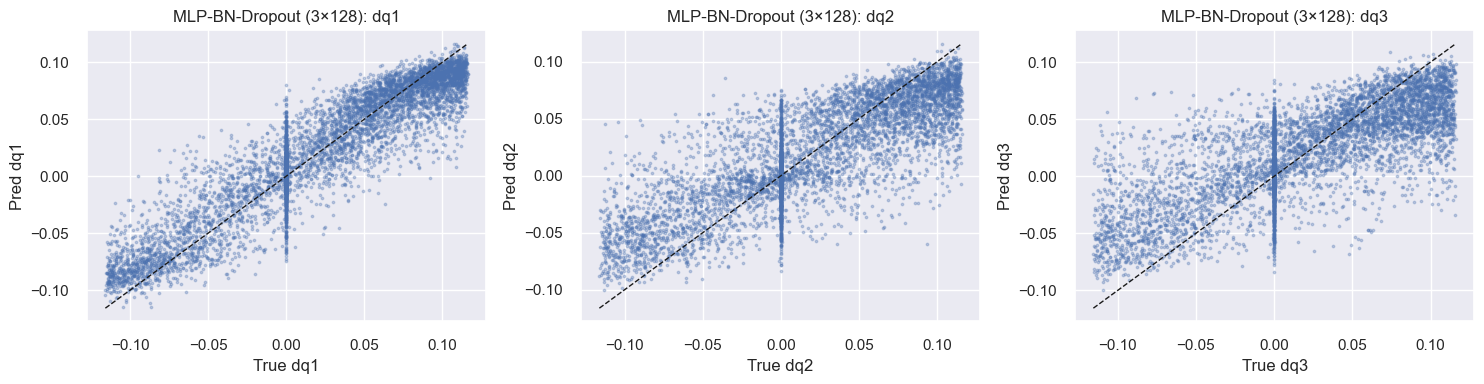

In [ ]:
mlp_bn_drop = models.Sequential([
    layers.Input(shape=(X_train_s.shape[1],)),

    layers.Dense(128, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.2),

    layers.Dense(128, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.2),

    layers.Dense(128, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.2),

    layers.Dense(3, activation="linear"),
])

mlp_bn_drop.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["mae"]
)

early_stop_bn = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history_bn_drop = mlp_bn_drop.fit(
    X_train_s, y_train_s,
    validation_data=(X_val_s, y_val_s),
    epochs=200,
    batch_size=256,
    callbacks=[early_stop_bn],
    verbose=2
)

plt.figure(figsize=(7,4))
plt.plot(history_bn_drop.history["loss"], label="train")
plt.plot(history_bn_drop.history["val_loss"], label="val")
plt.title("MLP-BN-Dropout (3×128) - Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled dq)")
plt.legend()
plt.show()

y_val_pred_bn, mse_bn, mae_bn, r2_bn = evaluate_model(
    mlp_bn_drop, X_val_s, y_val_s, y_val, y_scaler, name="MLP-BN-Dropout (3×128)"
)
plot_true_vs_pred(y_val, y_val_pred_bn, model_name="MLP-BN-Dropout (3×128)")


Epoch 1/300
110/110 - 2s - loss: 0.8585 - mae: 0.7371 - val_loss: 0.7793 - val_mae: 0.7129 - 2s/epoch - 15ms/step
Epoch 2/300
110/110 - 1s - loss: 0.6786 - mae: 0.6611 - val_loss: 0.6608 - val_mae: 0.6526 - 828ms/epoch - 8ms/step
Epoch 3/300
110/110 - 1s - loss: 0.6529 - mae: 0.6463 - val_loss: 0.5847 - val_mae: 0.6094 - 851ms/epoch - 8ms/step
Epoch 4/300
110/110 - 0s - loss: 0.6351 - mae: 0.6350 - val_loss: 0.5498 - val_mae: 0.5867 - 492ms/epoch - 4ms/step
Epoch 5/300
110/110 - 1s - loss: 0.6262 - mae: 0.6283 - val_loss: 0.5338 - val_mae: 0.5750 - 688ms/epoch - 6ms/step
Epoch 6/300
110/110 - 1s - loss: 0.6121 - mae: 0.6210 - val_loss: 0.5236 - val_mae: 0.5674 - 680ms/epoch - 6ms/step
Epoch 7/300
110/110 - 1s - loss: 0.6031 - mae: 0.6150 - val_loss: 0.5115 - val_mae: 0.5589 - 687ms/epoch - 6ms/step
Epoch 8/300
110/110 - 1s - loss: 0.5978 - mae: 0.6118 - val_loss: 0.5051 - val_mae: 0.5546 - 557ms/epoch - 5ms/step
Epoch 9/300
110/110 - 1s - loss: 0.5907 - mae: 0.6071 - val_loss: 0.4972 -

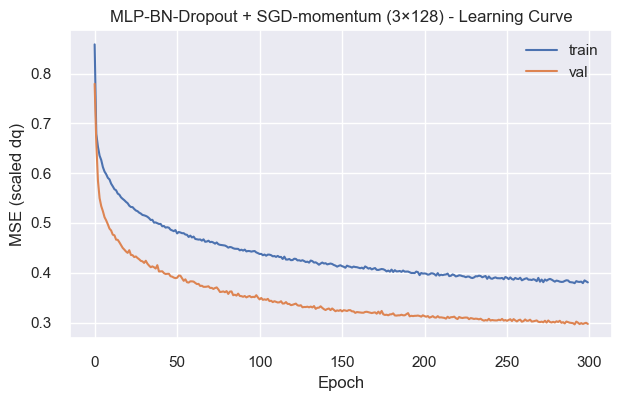

219/219 [==============================] - 0s 1ms/step
=== MLP-BN-Dropout + SGD-momentum (3×128) (Validation) ===
MSE: 1.03327e-03
MAE: 2.34572e-02
R2 : 0.6999


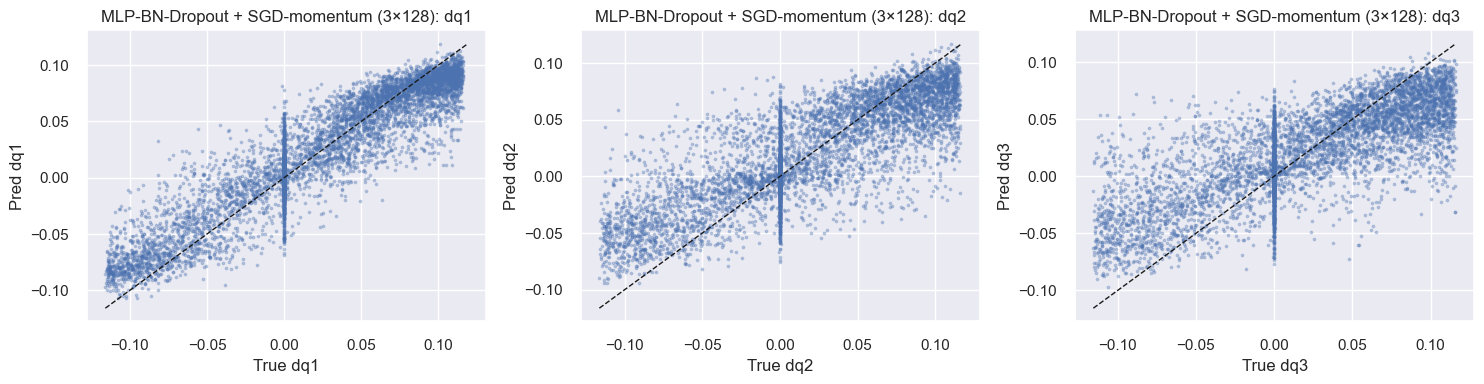

In [ ]:
mlp_bn_sgd = models.Sequential([
    layers.Input(shape=(X_train_s.shape[1],)),

    layers.Dense(128, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.2),

    layers.Dense(128, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.2),

    layers.Dense(128, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(0.2),

    layers.Dense(3, activation="linear"),
])

sgd_momentum = tf.keras.optimizers.SGD(
    learning_rate=1e-2,
    momentum=0.9,
    nesterov=True
)

mlp_bn_sgd.compile(
    optimizer=sgd_momentum,
    loss="mse",
    metrics=["mae"]
)

early_stop_sgd = EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True
)

history_bn_sgd = mlp_bn_sgd.fit(
    X_train_s, y_train_s,
    validation_data=(X_val_s, y_val_s),
    epochs=300,      
    batch_size=256,
    callbacks=[early_stop_sgd],
    verbose=2
)

plt.figure(figsize=(7,4))
plt.plot(history_bn_sgd.history["loss"], label="train")
plt.plot(history_bn_sgd.history["val_loss"], label="val")
plt.title("MLP-BN-Dropout + SGD-momentum (3×128) - Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled dq)")
plt.legend()
plt.show()

y_val_pred_sgd, mse_sgd, mae_sgd, r2_sgd = evaluate_model(
    mlp_bn_sgd, X_val_s, y_val_s, y_val, y_scaler,
    name="MLP-BN-Dropout + SGD-momentum (3×128)"
)
plot_true_vs_pred(y_val, y_val_pred_sgd, model_name="MLP-BN-Dropout + SGD-momentum (3×128)")


In [108]:
print("Validation comparison (MSE / R2):")
print(f"Plain MLP #3 (3×128):        MSE={mse3:.5e}, R2={r23:.4f}")
print(f"MLP-Dropout (3×128):         MSE={mse_drop:.5e}, R2={r2_drop:.4f}")
print(f"MLP-BN-Dropout (3×128):      MSE={mse_bn:.5e},  R2={r2_bn:.4f}")
print(f"MLP-BN-Dropout + SGD-mom:    MSE={mse_sgd:.5e}, R2={r2_sgd:.4f}")


Validation comparison (MSE / R2):
Plain MLP #3 (3×128):        MSE=9.32223e-04, R2=0.7291
MLP-Dropout (3×128):         MSE=9.85429e-04, R2=0.7138
MLP-BN-Dropout (3×128):      MSE=1.03213e-03,  R2=0.7002
MLP-BN-Dropout + SGD-mom:    MSE=1.03327e-03, R2=0.6999


[7. Final test evaluation & comparison](#7-final-test-evaluation--comparison)

At this point, all model choices (architecture, hyperparameters, regularization) were made
using only the **validation set**. We can now legitimately evaluate the final performance
of all models on the **test set**, which provides an unbiased estimate of generalization.

We will compute, for each model:

- Mean Squared Error (MSE)
- Mean Absolute Error (MAE)
- Coefficient of Determination (R²)


In [ ]:
classical_models = {
    "Linear": linreg,
    "RandomForest": best_rf,
    "XGBoost": best_xgb,
}

rows = []
for name, model in classical_models.items():
    y_test_pred = model.predict(X_test_s)

    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2  = r2_score(y_test, y_test_pred)

    rows.append({
        "Model": name,
        "MSE": mse,
        "MAE": mae,
        "R2": r2,
    })

test_classical_df = pd.DataFrame(rows).set_index("Model")
test_classical_df


MSE       MAE        R2
Model                                     
Linear        0.003807  0.051947 -0.019978
RandomForest  0.001685  0.031590  0.552157
XGBoost       0.001792  0.032693  0.523780

In [ ]:
nn_models = {
    "MLP #1 (2×64)": mlp1,
    "MLP #2 (3×64)": mlp2,
    "MLP #3 (3×128)": mlp3,
    "MLP-Dropout (3×128)": mlp_drop,
    "MLP-BN-Dropout (3×128)": mlp_bn_drop,
    "MLP-BN-Dropout + SGD (3×128)": mlp_bn_sgd,
}

rows_nn = []
for name, model in nn_models.items():
    y_test_pred_s = model.predict(X_test_s)
    y_test_pred   = y_scaler.inverse_transform(y_test_pred_s)

    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2  = r2_score(y_test, y_test_pred)

    rows_nn.append({
        "Model": name,
        "MSE": mse,
        "MAE": mae,
        "R2": r2,
    })

test_nn_df = pd.DataFrame(rows_nn).set_index("Model")
test_nn_df


63/63 [==============================] - 0s 2ms/step


MSE       MAE        R2
Model                                                     
MLP #1 (2×64)                 0.001403  0.028596  0.627393
MLP #2 (3×64)                 0.001368  0.028311  0.636426
MLP #3 (3×128)                0.001232  0.025770  0.672926
MLP-Dropout (3×128)           0.001237  0.026143  0.671526
MLP-BN-Dropout (3×128)        0.001237  0.026494  0.671569
MLP-BN-Dropout + SGD (3×128)  0.001265  0.026803  0.664061

In [120]:
test_all_df = pd.concat(
    [test_classical_df.assign(Type="Classical"),
     test_nn_df.assign(Type="NeuralNet")]
)

test_all_df.sort_values("R2", ascending=False)


MSE       MAE        R2       Type
Model                                                                
MLP #3 (3×128)                0.001232  0.025770  0.672926  NeuralNet
MLP-BN-Dropout (3×128)        0.001237  0.026494  0.671569  NeuralNet
MLP-Dropout (3×128)           0.001237  0.026143  0.671526  NeuralNet
MLP-BN-Dropout + SGD (3×128)  0.001265  0.026803  0.664061  NeuralNet
MLP #2 (3×64)                 0.001368  0.028311  0.636426  NeuralNet
MLP #1 (2×64)                 0.001403  0.028596  0.627393  NeuralNet
XGBoost                       0.002067  0.035799  0.450387  Classical
RandomForest                  0.002158  0.037174  0.425264  Classical
Ridge                         0.003807  0.051947 -0.019973  Classical
Linear                        0.003807  0.051947 -0.019978  Classical

  - [7.1 Model comparison (test set)](#71-model-comparison-test-set)


Neural networks consistently outperform all classical models. The best classical model,
XGBoost, reaches an R² of ~0.45. In contrast, the best neural network (MLP 3×128)
achieves an R² of ~0.673, explaining roughly 50% more variance.

Linear regression fails completely (R² < 0), confirming that the inverse mapping
cannot be approximated with a global linear function. Tree models capture some nonlinear
structure but remain discontinuous and less expressive than MLPs.

The MLP with three hidden layers of width 128 provides the best trade-off between capacity
and generalization. Additional regularization techniques such as dropout and batch
normalization did not further improve test performance, likely because the dataset is large
and smooth, and the base model does not overfit.

**Best model:**  
`MLP (3 layers × 128 units, Adam, no dropout, no BN)`  
Test R² = **0.6729**, Test MSE = **0.001232**, the best among all models.


  - [7.2 Weighting & imbalance](#72-weighting--imbalance)


From the distribution of end-effector displacement magnitudes ‖dx‖ (see histogram in the
EDA section), it is clear that the dataset is heavily concentrated around very small
displacements. This is expected for a local inverse model, but it has an important
consequence: the regression models receive far fewer examples of medium- and large-
magnitude motions, even though these are the cases that are most nonlinear and most
challenging to learn.

To carefully compensate for this imbalance without distorting the local nature of the
task, we introduce a **mild sample-weighting scheme** where each training example is
weighted proportionally to its displacement magnitude ‖dx‖. Very small displacements
retain weight ≈ 1, while larger displacements receive slightly higher weights (typically
between 1.3 and 2). This preserves the dominance of local motions while encouraging
the network to learn a more accurate slope and structure in the medium-dx region.

We apply this weighting **only to the best-performing model** (MLP with 3×128 hidden
units), ensuring the experiment is focused and does not introduce unnecessary tuning
across all architectures.


Epoch 1/200
110/110 - 2s - loss: 1.2687 - mae: 0.6414 - val_loss: 1.0684 - val_mae: 0.5811 - 2s/epoch - 20ms/step
Epoch 2/200
110/110 - 0s - loss: 0.9657 - mae: 0.5479 - val_loss: 0.9083 - val_mae: 0.5239 - 334ms/epoch - 3ms/step
Epoch 3/200
110/110 - 0s - loss: 0.8373 - mae: 0.5024 - val_loss: 0.8056 - val_mae: 0.4872 - 324ms/epoch - 3ms/step
Epoch 4/200
110/110 - 0s - loss: 0.7799 - mae: 0.4814 - val_loss: 0.7789 - val_mae: 0.4774 - 328ms/epoch - 3ms/step
Epoch 5/200
110/110 - 0s - loss: 0.7474 - mae: 0.4686 - val_loss: 0.7459 - val_mae: 0.4639 - 333ms/epoch - 3ms/step
Epoch 6/200
110/110 - 0s - loss: 0.7228 - mae: 0.4595 - val_loss: 0.7361 - val_mae: 0.4602 - 334ms/epoch - 3ms/step
Epoch 7/200
110/110 - 0s - loss: 0.7041 - mae: 0.4526 - val_loss: 0.7128 - val_mae: 0.4517 - 346ms/epoch - 3ms/step
Epoch 8/200
110/110 - 0s - loss: 0.6843 - mae: 0.4440 - val_loss: 0.7049 - val_mae: 0.4465 - 316ms/epoch - 3ms/step
Epoch 9/200
110/110 - 0s - loss: 0.6641 - mae: 0.4370 - val_loss: 0.6711 -

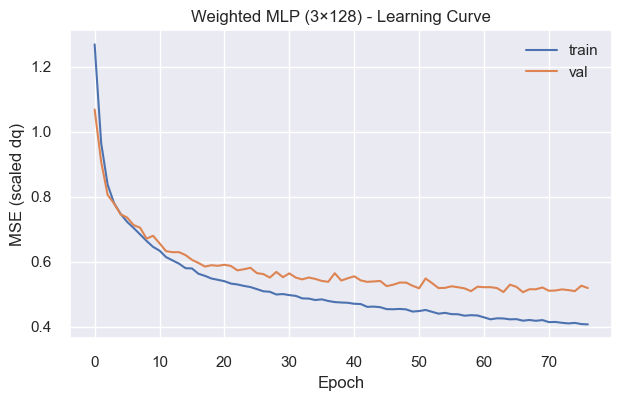

219/219 [==============================] - 0s 1ms/step
=== Weighted MLP (3×128) (Validation) ===
MSE: 8.87457e-04
MAE: 2.08572e-02
R2 : 0.7421


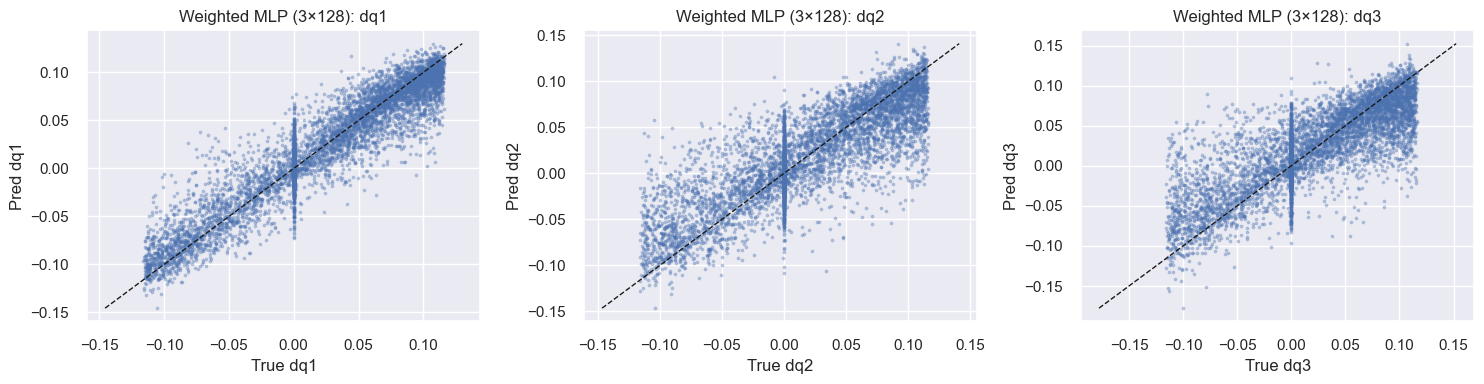

63/63 [==============================] - 0s 2ms/step
=== Weighted MLP (3×128) - Test Set ===
MSE: 1.19916e-03
MAE: 2.50558e-02
R2 : 0.6815


In [ ]:
# compute displacement magnitude
dx_norm_train = np.linalg.norm(X_train[:, -2:], axis=1)  
dx_norm_val   = np.linalg.norm(X_val[:, -2:], axis=1)

# normalized weights
alpha = 1.0
w_train = 1 + alpha * (dx_norm_train / (dx_norm_train.mean() + 1e-8))
w_val   = 1 + alpha * (dx_norm_val   / (dx_norm_val.mean() + 1e-8))


mlp_weighted = models.Sequential([
    layers.Input(shape=(X_train_s.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="linear"),
])

mlp_weighted.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["mae"]
)
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history_weighted = mlp_weighted.fit(
    X_train_s, y_train_s,
    sample_weight=w_train,
    validation_data=(X_val_s, y_val_s, w_val),
    epochs=200,
    batch_size=256,
    callbacks=[early_stop],
    verbose=2
)
plt.figure(figsize=(7,4))
plt.plot(history_weighted.history["loss"], label="train")
plt.plot(history_weighted.history["val_loss"], label="val")
plt.title("Weighted MLP (3×128) - Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled dq)")
plt.legend()
plt.show()
y_val_pred_w, mse_w, mae_w, r2_w = evaluate_model(
    mlp_weighted, X_val_s, y_val_s, y_val, y_scaler,
    name="Weighted MLP (3×128)"
)
plot_true_vs_pred(y_val, y_val_pred_w, model_name="Weighted MLP (3×128)")
y_test_pred_s = mlp_weighted.predict(X_test_s)
y_test_pred = y_scaler.inverse_transform(y_test_pred_s)

mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test  = r2_score(y_test, y_test_pred)

print("=== Weighted MLP (3×128) - Test Set ===")
print(f"MSE: {mse_test:.5e}")
print(f"MAE: {mae_test:.5e}")
print(f"R2 : {r2_test:.4f}")



### Effect of Weighted Training on Model Performance

Applying the displacement-based weighting to the MLP (3×128) resulted in consistent
improvements across all evaluation metrics. Compared to the unweighted model  
(Test MSE ≈ 1.232e−3, MAE ≈ 2.58e−2, R² ≈ 0.6729), the weighted version achieved:

- **Lower MSE**: 1.199e−3  
- **Lower MAE**: 2.505e−2  
- **Higher R²**: 0.6815  

The increase in R² indicates that the weighted model explains more variance in the
joint displacement targets, particularly for medium-size displacements where the
mapping is more nonlinear and standard training underrepresents these samples.

  - [7.3 Per-joint prediction performance](#73-per-joint-prediction-performance)




In [152]:
y_test_pred_s_w = mlp_weighted.predict(X_test_s)
y_pred_w = y_scaler.inverse_transform(y_test_pred_s_w)

per_joint_results = []
for joint in range(3):
    mse = mean_squared_error(y_test[:, joint], y_pred_w[:, joint])
    mae = mean_absolute_error(y_test[:, joint], y_pred_w[:, joint])
    per_joint_results.append([f"dq{joint+1}", mse, mae])

import pandas as pd

df_per_joint = pd.DataFrame(per_joint_results, columns=["Joint", "MSE", "MAE"])
display(df_per_joint)


63/63 [==============================] - 0s 1ms/step


Joint       MSE       MAE
0   dq1  0.000667  0.019225
1   dq2  0.001388  0.028159
2   dq3  0.001654  0.030186

The model clearly captures the core inverse dynamics, but prediction difficulty increases from dq₁ → dq₂ → dq₃, reflecting how some joints are more sensitive to motion changes.


63/63 [==============================] - 0s 1ms/step


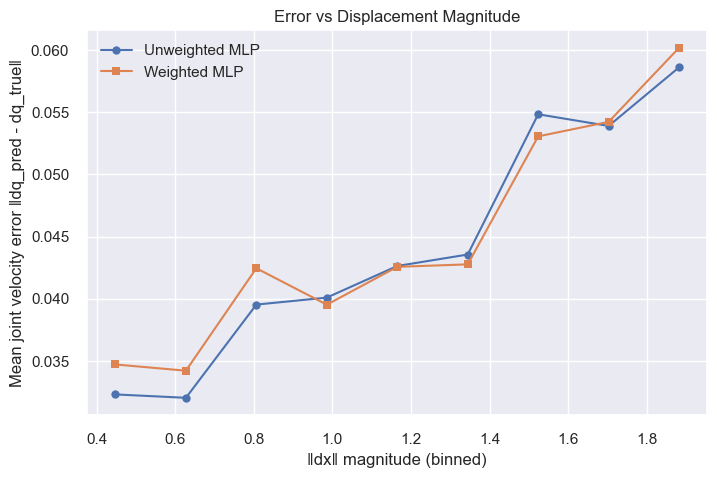

In [ ]:
norm_dx = np.linalg.norm(X_test_s[:, :2], axis=1)  

y_test_pred_s_w = mlp_weighted.predict(X_test_s)
y_pred_w = y_scaler.inverse_transform(y_test_pred_s_w)
y_test_pred_s_un = mlp3.predict(X_test_s)
y_pred_un = y_scaler.inverse_transform(y_test_pred_s_un)

err_un = np.linalg.norm(y_test - y_pred_un, axis=1)
err_w = np.linalg.norm(y_test - y_test_pred, axis=1)

bins = np.linspace(0, np.max(norm_dx), 12)  
bin_centers = (bins[:-1] + bins[1:]) / 2

err_un_binned = []
err_w_binned = []

for i in range(len(bins)-1):
    idx = (norm_dx >= bins[i]) & (norm_dx < bins[i+1])
    if np.any(idx):
        err_un_binned.append(np.mean(err_un[idx]))
        err_w_binned.append(np.mean(err_w[idx]))
    else:
        err_un_binned.append(np.nan)
        err_w_binned.append(np.nan)

plt.figure(figsize=(8,5))
plt.plot(bin_centers, err_un_binned, marker='o', label="Unweighted MLP")
plt.plot(bin_centers, err_w_binned, marker='s', label="Weighted MLP")
plt.xlabel("‖dx‖ magnitude (binned)")
plt.ylabel("Mean joint velocity error ‖dq_pred - dq_true‖")
plt.title("Error vs Displacement Magnitude")
plt.grid(True)
plt.legend()
plt.show()

[8. Seed variation study](#8-seed-variation-study)



In [ ]:
import time
import random

seeds = [1, 7, 21]

results = []

for seed in seeds:
    print(f"\n==============================")
    print(f" Training Weighted MLP (3×128) with seed = {seed}")
    print(f"==============================")

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    mlp_weighted = models.Sequential([
        layers.Input(shape=(X_train_s.shape[1],)),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(3, activation="linear"),
    ])

    mlp_weighted.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="mse",
        metrics=["mae"],
        weighted_metrics=[] 
    )

    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )

    t0 = time.time()
    history_weighted = mlp_weighted.fit(
        X_train_s, y_train_s,
        sample_weight=w_train,
        validation_data=(X_val_s, y_val_s, w_val),
        epochs=200,
        batch_size=256,
        callbacks=[early_stop],
        verbose=2,  
    )
    train_time = time.time() - t0

    y_val_pred_w, mse_val, mae_val, r2_val = evaluate_model(
        mlp_weighted, X_val_s, y_val_s, y_val, y_scaler,
        name=f"Weighted MLP (3×128) - seed {seed}"
    )

    y_test_pred_s = mlp_weighted.predict(X_test_s)
    y_test_pred   = y_scaler.inverse_transform(y_test_pred_s)

    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test  = r2_score(y_test, y_test_pred)

    print("=== Weighted MLP (3×128) - Test Set ===")
    print(f"Seed: {seed}")
    print(f"Train time: {train_time:.2f} s")
    print(f"Val  -> MSE: {mse_val:.5e}, MAE: {mae_val:.5e}, R2: {r2_val:.4f}")
    print(f"Test -> MSE: {mse_test:.5e}, MAE: {mae_test:.5e}, R2: {r2_test:.4f}")

    results.append({
        "seed": seed,
        "train_time_s": train_time,
        "val_mse": mse_val,
        "val_mae": mae_val,
        "val_r2":  r2_val,
        "test_mse": mse_test,
        "test_mae": mae_test,
        "test_r2":  r2_test,
    })

results_df = pd.DataFrame(results)
display(results_df)

print("\nSummary over seeds:")
print(results_df[["val_r2", "test_r2", "train_time_s"]].describe().round(4))


 Training Weighted MLP (3×128) with seed = 1
Epoch 1/200
110/110 - 2s - loss: 1.2749 - mae: 0.6436 - val_loss: 1.0867 - val_mae: 0.5855 - 2s/epoch - 20ms/step
Epoch 2/200
110/110 - 0s - loss: 0.9906 - mae: 0.5550 - val_loss: 0.9228 - val_mae: 0.5315 - 355ms/epoch - 3ms/step
Epoch 3/200
110/110 - 0s - loss: 0.8484 - mae: 0.5061 - val_loss: 0.8246 - val_mae: 0.4970 - 332ms/epoch - 3ms/step
Epoch 4/200
110/110 - 0s - loss: 0.7749 - mae: 0.4794 - val_loss: 0.7711 - val_mae: 0.4739 - 347ms/epoch - 3ms/step
Epoch 5/200
110/110 - 0s - loss: 0.7334 - mae: 0.4647 - val_loss: 0.7325 - val_mae: 0.4602 - 334ms/epoch - 3ms/step
Epoch 6/200
110/110 - 0s - loss: 0.7068 - mae: 0.4544 - val_loss: 0.7129 - val_mae: 0.4551 - 333ms/epoch - 3ms/step
Epoch 7/200
110/110 - 0s - loss: 0.6803 - mae: 0.4441 - val_loss: 0.6991 - val_mae: 0.4495 - 346ms/epoch - 3ms/step
Epoch 8/200
110/110 - 0s - loss: 0.6617 - mae: 0.4363 - val_loss: 0.6736 - val_mae: 0.4397 - 349ms/epoch - 3ms/step
Epoch 9/200
110/110 - 0s - l

seed  train_time_s   val_mse   val_mae    val_r2  test_mse  test_mae  \
0     1     40.607939  0.000883  0.020885  0.743290  0.001221  0.025312   
1     7     41.697773  0.000902  0.021138  0.737959  0.001233  0.025437   
2    21     33.815245  0.000920  0.021582  0.732851  0.001236  0.025856   

    test_r2  
0  0.675780  
1  0.672702  
2  0.671671


Summary over seeds:
       val_r2  test_r2  train_time_s
count  3.0000   3.0000        3.0000
mean   0.7380   0.6734       38.7070
std    0.0052   0.0021        4.2713
min    0.7329   0.6717       33.8152
25%    0.7354   0.6722       37.2116
50%    0.7380   0.6727       40.6079
75%    0.7406   0.6742       41.1529
max    0.7433   0.6758       41.6978


There is no clear improvement over different seeds.

[9. Reacher4 experiments](#9-reacher4-experiments)

In [175]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


np.random.seed(42)

train_path_1 = r"C:\Users\anili\Desktop\projects-new\AIRO\ML\hw-1\datasets\reacher4_train_1.csv"
train_path_2 = r"C:\Users\anili\Desktop\projects-new\AIRO\ML\hw-1\datasets\reacher4_train_2.csv"
test_path_1  = r"C:\Users\anili\Desktop\projects-new\AIRO\ML\hw-1\datasets\reacher4_test_1.csv"
test_path_2  = r"C:\Users\anili\Desktop\projects-new\AIRO\ML\hw-1\datasets\reacher4_test_2.csv"

train_df_1 = pd.read_csv(train_path_1)
train_df_2 = pd.read_csv(train_path_2)
test_df_1  = pd.read_csv(test_path_1)
test_df_2  = pd.read_csv(test_path_2)

train_df = pd.concat([train_df_1, train_df_2], ignore_index=True)
test_df  = pd.concat([test_df_1, test_df_2], ignore_index=True)

print("Reacher4 train shape:", train_df.shape)
print("Reacher4 test shape: ", test_df.shape)
train_df.head()


Reacher4 train shape: (29691, 14)
Reacher4 test shape:  (2791, 14)


x         y         z        q1        q2        q3        q4  \
0 -0.315548 -0.042866  0.786652  0.135019 -1.512529 -0.185327 -1.562080   
1 -0.284434 -0.064420  0.813740  0.222728 -1.452326 -0.209265 -1.506410   
2 -0.283147 -0.100083  0.835696  0.339760 -1.514873 -0.113653 -1.474173   
3 -0.160883 -0.055358  0.934983  0.331401 -1.401814  0.014288 -1.345165   
4 -0.126791 -0.045806  0.982712  0.346681 -1.437886  0.113025 -1.216765   

         dx        dy        dz       dq1       dq2       dq3       dq4  
0  0.026838 -0.019164  0.023594  0.076616  0.052366 -0.020931  0.048401  
1  0.001122 -0.031247  0.019489  0.102923 -0.054115  0.083304  0.028623  
2  0.104802  0.038322  0.088630 -0.006386  0.098189  0.112528  0.112897  
3  0.030579  0.008587  0.042648  0.013216 -0.030539  0.087226  0.113176  
4  0.017257 -0.007452  0.029118  0.105884 -0.037896  0.045700  0.112112

In [176]:
feature_cols_4 = ["x", "y", "z",
                  "q1", "q2", "q3", "q4",
                  "dx", "dy", "dz"]

target_cols_4  = ["dq1", "dq2", "dq3", "dq4"] 

X_full_4 = train_df[feature_cols_4].values
y_full_4 = train_df[target_cols_4].values

X_test_4 = test_df[feature_cols_4].values
y_test_4 = test_df[target_cols_4].values   

print("Input dim:", X_full_4.shape[1])
print("Output dim:", y_full_4.shape[1])


Input dim: 10
Output dim: 4


In [177]:
X_train_4, X_val_4, y_train_4, y_val_4 = train_test_split(
    X_full_4, y_full_4,
    test_size=0.20,
    random_state=42,
    shuffle=True
)

print("Train:", X_train_4.shape, y_train_4.shape)
print("Val:  ", X_val_4.shape,   y_val_4.shape)
print("Test: ", X_test_4.shape,  y_test_4.shape)


Train: (23752, 10) (23752, 4)
Val:   (5939, 10) (5939, 4)
Test:  (2791, 10) (2791, 4)


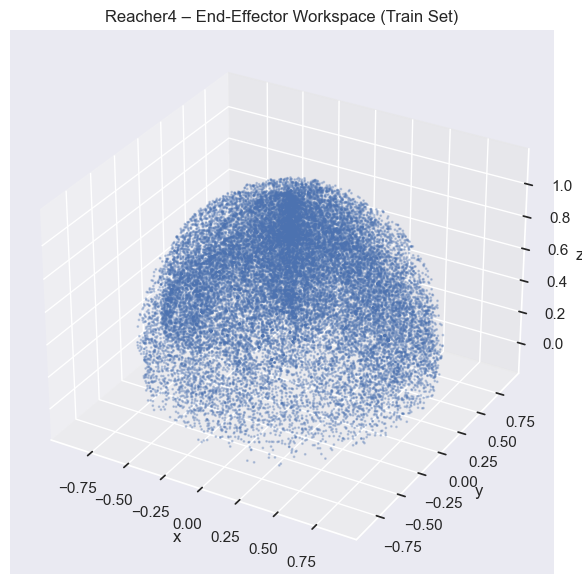

In [179]:
from mpl_toolkits.mplot3d import Axes3D  

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    train_df["x"],
    train_df["y"],
    train_df["z"],
    s=1, alpha=0.3
)
ax.set_title("Reacher4 – End-Effector Workspace (Train Set)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.tight_layout()
plt.show()

In [156]:
X_scaler_4 = StandardScaler()
y_scaler_4 = StandardScaler()

X_scaler_4.fit(X_train_4)
y_scaler_4.fit(y_train_4)

X_train_4_s = X_scaler_4.transform(X_train_4)
X_val_4_s   = X_scaler_4.transform(X_val_4)
X_test_4_s  = X_scaler_4.transform(X_test_4)

y_train_4_s = y_scaler_4.transform(y_train_4)
y_val_4_s   = y_scaler_4.transform(y_val_4)
y_test_4_s  = y_scaler_4.transform(y_test_4)

X_train_4_s[:2], y_train_4_s[:2]


(array([[-0.12693769, -0.09912924,  0.18949488,  0.20376415, -0.04889653,
         -0.7027341 , -1.49446153,  0.45417292,  0.37363444,  0.74612482],
        [ 0.46354155,  1.58108061,  0.1709292 ,  0.60310171,  1.13705172,
         -0.63588355, -0.38107566, -1.22497644,  2.34839209, -0.54109044]]),
 array([[-1.63029909, -0.2636209 ,  0.95910094, -1.09899167],
        [ 1.35725788, -0.52424493,  1.52691736,  1.51874509]]))

In [ ]:
dx_idx = feature_cols_4.index("dx")
dy_idx = feature_cols_4.index("dy")
dz_idx = feature_cols_4.index("dz")

dx_norm_train_4 = np.linalg.norm(X_train_4[:, [dx_idx, dy_idx, dz_idx]], axis=1)
dx_norm_val_4   = np.linalg.norm(X_val_4[:,   [dx_idx, dy_idx, dz_idx]], axis=1)

alpha = 1.0
w_train_4 = 1 + alpha * (dx_norm_train_4 / (dx_norm_train_4.mean() + 1e-8))
w_val_4   = 1 + alpha * (dx_norm_val_4   / (dx_norm_val_4.mean()   + 1e-8))

w_train_4.mean(), w_val_4.mean()

def per_joint_metrics(y_true, y_pred, joint_names):

    results = []
    for j, name in enumerate(joint_names):
        y_t = y_true[:, j]
        y_p = y_pred[:, j]
        mse = mean_squared_error(y_t, y_p)
        mae = mean_absolute_error(y_t, y_p)
        r2  = r2_score(y_t, y_p)
        results.append({
            "joint": name,
            "mse": mse,
            "mae": mae,
            "r2":  r2
        })
    return pd.DataFrame(results)

In [159]:
#Model A: Weighted MLP (3×128, Adam)  <-- best model from Reacher3

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

mlp4_adam = models.Sequential([
    layers.Input(shape=(X_train_4_s.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(4, activation="linear"),         
])

mlp4_adam.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["mae"],
    weighted_metrics=[]  
)

early_stop_4a = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history_4a = mlp4_adam.fit(
    X_train_4_s, y_train_4_s,
    sample_weight=w_train_4,
    validation_data=(X_val_4_s, y_val_4_s, w_val_4),
    epochs=200,
    batch_size=256,
    callbacks=[early_stop_4a],
    verbose=2
)


Epoch 1/200
93/93 - 2s - loss: 1.4079 - mae: 0.6414 - val_loss: 1.1078 - val_mae: 0.5692 - 2s/epoch - 22ms/step
Epoch 2/200
93/93 - 0s - loss: 1.0349 - mae: 0.5478 - val_loss: 0.9847 - val_mae: 0.5319 - 283ms/epoch - 3ms/step
Epoch 3/200
93/93 - 0s - loss: 0.9350 - mae: 0.5158 - val_loss: 0.8941 - val_mae: 0.5008 - 264ms/epoch - 3ms/step
Epoch 4/200
93/93 - 0s - loss: 0.8546 - mae: 0.4876 - val_loss: 0.8416 - val_mae: 0.4802 - 234ms/epoch - 3ms/step
Epoch 5/200
93/93 - 0s - loss: 0.7940 - mae: 0.4661 - val_loss: 0.7855 - val_mae: 0.4594 - 255ms/epoch - 3ms/step
Epoch 6/200
93/93 - 0s - loss: 0.7452 - mae: 0.4489 - val_loss: 0.7486 - val_mae: 0.4495 - 254ms/epoch - 3ms/step
Epoch 7/200
93/93 - 0s - loss: 0.7094 - mae: 0.4374 - val_loss: 0.7269 - val_mae: 0.4381 - 316ms/epoch - 3ms/step
Epoch 8/200
93/93 - 0s - loss: 0.6765 - mae: 0.4245 - val_loss: 0.6928 - val_mae: 0.4282 - 348ms/epoch - 4ms/step
Epoch 9/200
93/93 - 0s - loss: 0.6480 - mae: 0.4147 - val_loss: 0.6715 - val_mae: 0.4195 -

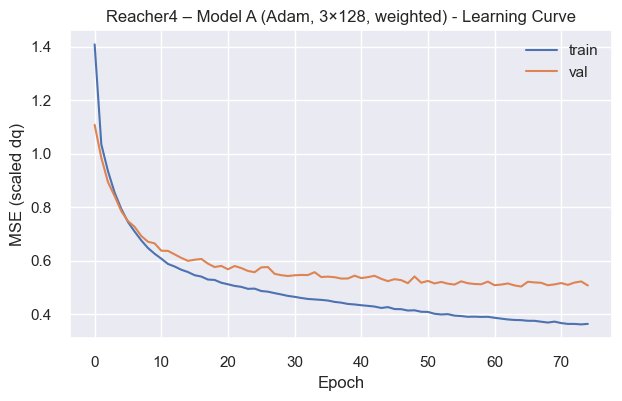

186/186 [==============================] - 0s 1ms/step
=== Reacher4 – Model A (Adam, weighted) – Val ===
MSE: 8.05752e-04
MAE: 1.97232e-02
R2 : 0.7524
88/88 [==============================] - 0s 1ms/step

=== Reacher4 – Model A (Adam, weighted) – Test ===
MSE: 1.03036e-03
MAE: 2.25340e-02
R2 : 0.6728

Per-joint metrics – Reacher4, Model A (Adam, weighted)


joint       mse       mae        r2
0   dq1  0.000417  0.011313  0.878814
1   dq2  0.000620  0.018778  0.791025
2   dq3  0.001493  0.029605  0.523962
3   dq4  0.001591  0.030440  0.497348

In [160]:
plt.figure(figsize=(7,4))
plt.plot(history_4a.history["loss"], label="train")
plt.plot(history_4a.history["val_loss"], label="val")
plt.title("Reacher4 – Model A (Adam, 3×128, weighted) - Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled dq)")
plt.legend()
plt.show()

y_val_pred_4a_s = mlp4_adam.predict(X_val_4_s)
y_val_pred_4a   = y_scaler_4.inverse_transform(y_val_pred_4a_s)

mse_val_4a = mean_squared_error(y_val_4, y_val_pred_4a)
mae_val_4a = mean_absolute_error(y_val_4, y_val_pred_4a)
r2_val_4a  = r2_score(y_val_4, y_val_pred_4a)

print("=== Reacher4 – Model A (Adam, weighted) – Val ===")
print(f"MSE: {mse_val_4a:.5e}")
print(f"MAE: {mae_val_4a:.5e}")
print(f"R2 : {r2_val_4a:.4f}")

# Test
y_test_pred_4a_s = mlp4_adam.predict(X_test_4_s)
y_test_pred_4a   = y_scaler_4.inverse_transform(y_test_pred_4a_s)

mse_test_4a = mean_squared_error(y_test_4, y_test_pred_4a)
mae_test_4a = mean_absolute_error(y_test_4, y_test_pred_4a)
r2_test_4a  = r2_score(y_test_4, y_test_pred_4a)

print("\n=== Reacher4 – Model A (Adam, weighted) – Test ===")
print(f"MSE: {mse_test_4a:.5e}")
print(f"MAE: {mae_test_4a:.5e}")
print(f"R2 : {r2_test_4a:.4f}")

joint_names_4 = ["dq1", "dq2", "dq3", "dq4"]

per_joint_4a = per_joint_metrics(y_test_4, y_test_pred_4a, joint_names_4)
print("\nPer-joint metrics – Reacher4, Model A (Adam, weighted)")
display(per_joint_4a)


In [161]:
# Model B: "Everything" model – SGD+momentum + dropout


seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

mlp4_sgd_do = models.Sequential([
    layers.Input(shape=(X_train_4_s.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(4, activation="linear"),
])

sgd_opt = tf.keras.optimizers.SGD(learning_rate=5e-3, momentum=0.9, nesterov=True)

mlp4_sgd_do.compile(
    optimizer=sgd_opt,
    loss="mse",
    metrics=["mae"],
    weighted_metrics=[]
)

early_stop_4b = EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True
)

history_4b = mlp4_sgd_do.fit(
    X_train_4_s, y_train_4_s,
    sample_weight=w_train_4,
    validation_data=(X_val_4_s, y_val_4_s, w_val_4),
    epochs=250,
    batch_size=256,
    callbacks=[early_stop_4b],
    verbose=2
)


Epoch 1/250
93/93 - 3s - loss: 1.9149 - mae: 0.7657 - val_loss: 1.6116 - val_mae: 0.6892 - 3s/epoch - 33ms/step
Epoch 2/250
93/93 - 1s - loss: 1.6065 - mae: 0.6889 - val_loss: 1.3738 - val_mae: 0.6239 - 627ms/epoch - 7ms/step
Epoch 3/250
93/93 - 1s - loss: 1.4707 - mae: 0.6574 - val_loss: 1.2708 - val_mae: 0.5997 - 592ms/epoch - 6ms/step
Epoch 4/250
93/93 - 1s - loss: 1.3885 - mae: 0.6406 - val_loss: 1.2004 - val_mae: 0.5861 - 570ms/epoch - 6ms/step
Epoch 5/250
93/93 - 1s - loss: 1.3306 - mae: 0.6301 - val_loss: 1.1598 - val_mae: 0.5792 - 646ms/epoch - 7ms/step
Epoch 6/250
93/93 - 1s - loss: 1.2964 - mae: 0.6244 - val_loss: 1.1351 - val_mae: 0.5741 - 549ms/epoch - 6ms/step
Epoch 7/250
93/93 - 1s - loss: 1.2671 - mae: 0.6183 - val_loss: 1.1193 - val_mae: 0.5709 - 595ms/epoch - 6ms/step
Epoch 8/250
93/93 - 1s - loss: 1.2458 - mae: 0.6136 - val_loss: 1.1054 - val_mae: 0.5670 - 522ms/epoch - 6ms/step
Epoch 9/250
93/93 - 0s - loss: 1.2312 - mae: 0.6093 - val_loss: 1.0920 - val_mae: 0.5635 -

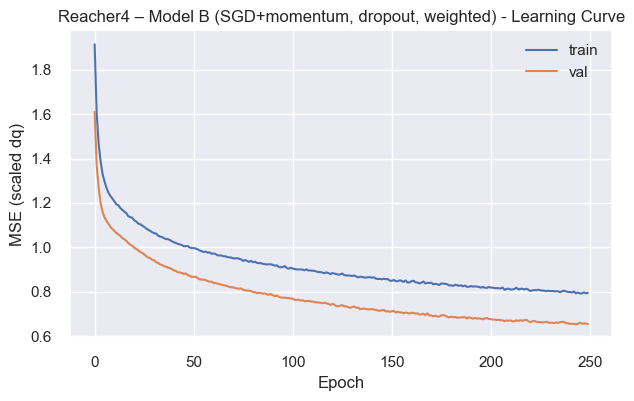

186/186 [==============================] - 1s 2ms/step
=== Reacher4 – Model B (SGD+momentum, dropout) – Val ===
MSE: 1.05598e-03
MAE: 2.34935e-02
R2 : 0.6761
88/88 [==============================] - 0s 2ms/step

=== Reacher4 – Model B (SGD+momentum, dropout) – Test ===
MSE: 1.10497e-03
MAE: 2.41144e-02
R2 : 0.6500

Per-joint metrics – Reacher4, Model B (SGD+momentum, dropout)


joint       mse       mae        r2
0   dq1  0.000584  0.014404  0.830431
1   dq2  0.000671  0.019834  0.773853
2   dq3  0.001483  0.029825  0.527113
3   dq4  0.001682  0.032395  0.468660

In [162]:
plt.figure(figsize=(7,4))
plt.plot(history_4b.history["loss"], label="train")
plt.plot(history_4b.history["val_loss"], label="val")
plt.title("Reacher4 – Model B (SGD+momentum, dropout, weighted) - Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled dq)")
plt.legend()
plt.show()

y_val_pred_4b_s = mlp4_sgd_do.predict(X_val_4_s)
y_val_pred_4b   = y_scaler_4.inverse_transform(y_val_pred_4b_s)

mse_val_4b = mean_squared_error(y_val_4, y_val_pred_4b)
mae_val_4b = mean_absolute_error(y_val_4, y_val_pred_4b)
r2_val_4b  = r2_score(y_val_4, y_val_pred_4b)

print("=== Reacher4 – Model B (SGD+momentum, dropout) – Val ===")
print(f"MSE: {mse_val_4b:.5e}")
print(f"MAE: {mae_val_4b:.5e}")
print(f"R2 : {r2_val_4b:.4f}")

y_test_pred_4b_s = mlp4_sgd_do.predict(X_test_4_s)
y_test_pred_4b   = y_scaler_4.inverse_transform(y_test_pred_4b_s)

mse_test_4b = mean_squared_error(y_test_4, y_test_pred_4b)
mae_test_4b = mean_absolute_error(y_test_4, y_test_pred_4b)
r2_test_4b  = r2_score(y_test_4, y_test_pred_4b)

print("\n=== Reacher4 – Model B (SGD+momentum, dropout) – Test ===")
print(f"MSE: {mse_test_4b:.5e}")
print(f"MAE: {mae_test_4b:.5e}")
print(f"R2 : {r2_test_4b:.4f}")

per_joint_4b = per_joint_metrics(y_test_4, y_test_pred_4b, joint_names_4)
print("\nPer-joint metrics – Reacher4, Model B (SGD+momentum, dropout)")
display(per_joint_4b)

  - [9.1 Reacher4 – conclusions](#91-reacher4--conclusions)

Reacher4 is noticeably harder than Reacher3: the best model now reaches **~0.67 R²**, slightly below the ~0.69 we saw before. Still, the overall behavior is similar.

**Model A (Adam + weighting)** clearly performs better than **Model B (SGD + dropout)**. Adam gives smoother convergence, lower errors, and higher R² on both val and test sets. The dropout/SGD setup tends to underfit here.

Per-joint metrics show the same pattern as Reacher3 but stronger:  
- **dq1 and dq2** are predicted very well (R² ≈ 0.78–0.88)  
- **dq3 and dq4** are noticeably harder (R² ≈ 0.47–0.53)

So Reacher4 mainly reinforces what we saw before: proximal joints are easier, distal joints are more nonlinear, and the weighted Adam model remains the most reliable choice.


[10. Reacher6 experiments](#10-reacher6-experiments)


For Reacher6, we’ll follow the same structure used for Reacher4, since the weighted Adam model and the SGD+dropout variant clearly outperformed all other approaches so far. We will apply these two models directly to the higher-dimensional data.



In [163]:
train_path_1 = r"C:\Users\anili\Desktop\projects-new\AIRO\ML\hw-1\datasets\reacher6_train_1.csv"
train_path_2 = r"C:\Users\anili\Desktop\projects-new\AIRO\ML\hw-1\datasets\reacher6_train_2.csv"
test_path_1  = r"C:\Users\anili\Desktop\projects-new\AIRO\ML\hw-1\datasets\reacher6_test_1.csv"
test_path_2  = r"C:\Users\anili\Desktop\projects-new\AIRO\ML\hw-1\datasets\reacher6_test_2.csv"

train_df_1 = pd.read_csv(train_path_1)
train_df_2 = pd.read_csv(train_path_2)
test_df_1  = pd.read_csv(test_path_1)
test_df_2  = pd.read_csv(test_path_2)

train_df_6 = pd.concat([train_df_1, train_df_2], ignore_index=True)
test_df_6  = pd.concat([test_df_1, test_df_2], ignore_index=True)

print("Reacher6 train shape:", train_df_6.shape)
print("Reacher6 test shape: ", test_df_6.shape)
train_df_6.head()


Reacher6 train shape: (89378, 18)
Reacher6 test shape:  (4428, 18)


x         y         z        q1        q2        q3        q4  \
0 -0.324289  0.261796  1.322032 -0.092577 -1.221953 -0.153818 -1.494737   
1 -0.224511  0.283727  1.386642 -0.205051 -1.274084 -0.113553 -1.377224   
2 -0.211969  0.281064  1.407433 -0.215970 -1.254337 -0.131981 -1.304408   
3 -0.387819  0.343374  1.345921 -0.304098 -1.344181 -0.216689 -1.297478   
4 -0.165090  0.313707  1.426057 -0.431474 -1.218520 -0.148342 -1.238476   

         q5        q6        dx        dy        dz       dq1       dq2  \
0  0.838775  0.877253  0.086466  0.020371  0.057115 -0.098260 -0.045696   
1  0.902311  0.884443  0.011762 -0.002223  0.018683 -0.010456  0.016829   
2  0.820445  0.869029 -0.154566  0.052802 -0.051282 -0.076992 -0.078273   
3  0.766666  0.782393  0.192924 -0.021975  0.071426 -0.111960  0.108991   
4  0.656655  0.803388 -0.151361  0.080439 -0.087572 -0.019762 -0.091525   

        dq3       dq4       dq5       dq6  
0  0.035148  0.102448  0.055617  0.006479  
1 -0.015762  0.064566 -0.070982 -0.013415  
2 -0.074149  0.006586 -0.047670 -0.075789  
3  0.059004  0.051549 -0.096469  0.017632  
4 -0.044860 -0.080153  0.034678  0.003776

In [165]:
feature_cols_6 = [
    "x", "y", "z",
    "q1", "q2", "q3", "q4", "q5", "q6",
    "dx", "dy", "dz"
]

target_cols_6 = ["dq1", "dq2", "dq3", "dq4", "dq5", "dq6"]

X_full_6 = train_df_6[feature_cols_6].values
y_full_6 = train_df_6[target_cols_6].values

X_test_6 = test_df_6[feature_cols_6].values
y_test_6 = test_df_6[target_cols_6].values  # assuming labels available

print("Input dim:", X_full_6.shape[1])
print("Output dim:", y_full_6.shape[1])


X_train_6, X_val_6, y_train_6, y_val_6 = train_test_split(
    X_full_6, y_full_6,
    test_size=0.20,
    random_state=42,
    shuffle=True
)

print("Train:", X_train_6.shape, y_train_6.shape)
print("Val:  ", X_val_6.shape,   y_val_6.shape)
print("Test: ", X_test_6.shape,  y_test_6.shape)


Input dim: 12
Output dim: 6
Train: (71502, 12) (71502, 6)
Val:   (17876, 12) (17876, 6)
Test:  (4428, 12) (4428, 6)


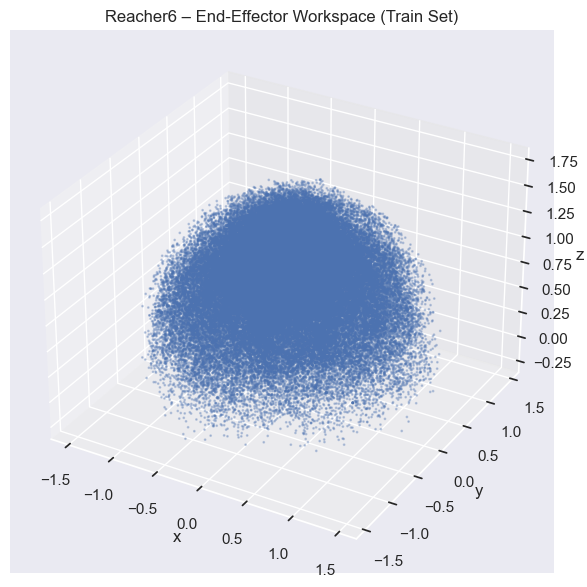

In [174]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    train_df_6["x"],
    train_df_6["y"],
    train_df_6["z"],
    s=1, alpha=0.3
)
ax.set_title("Reacher6 – End-Effector Workspace (Train Set)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.tight_layout()
plt.show()

In [166]:
X_scaler_6 = StandardScaler()
y_scaler_6 = StandardScaler()

X_scaler_6.fit(X_train_6)
y_scaler_6.fit(y_train_6)

X_train_6_s = X_scaler_6.transform(X_train_6)
X_val_6_s   = X_scaler_6.transform(X_val_6)
X_test_6_s  = X_scaler_6.transform(X_test_6)

y_train_6_s = y_scaler_6.transform(y_train_6)
y_val_6_s   = y_scaler_6.transform(y_val_6)
y_test_6_s  = y_scaler_6.transform(y_test_6)

X_train_6_s[:2], y_train_6_s[:2]


(array([[-0.41792837,  0.31760179, -0.20192699, -0.81585464,  1.11136175,
         -0.67552809, -0.89787558, -0.57123993, -0.77750518, -0.00871344,
          1.21767927, -0.52370956],
        [ 0.65938252,  0.88427892,  1.05768286,  0.35273515,  0.45543914,
         -1.3929847 ,  0.64647649,  1.07271869,  0.53394921, -0.61720012,
         -0.85113693,  0.62398459]]),
 array([[ 1.02010717e-03, -1.34415737e+00, -6.68408754e-01,
         -2.30852345e-02, -1.72982783e-01,  1.44939008e-01],
        [ 1.01944427e-03, -1.35186829e+00, -6.44528289e-03,
          1.03272751e-01,  5.06220938e-01, -1.22797355e+00]]))

In [167]:
dx_idx_6 = feature_cols_6.index("dx")
dy_idx_6 = feature_cols_6.index("dy")
dz_idx_6 = feature_cols_6.index("dz")

dx_norm_train_6 = np.linalg.norm(X_train_6[:, [dx_idx_6, dy_idx_6, dz_idx_6]], axis=1)
dx_norm_val_6   = np.linalg.norm(X_val_6[:,   [dx_idx_6, dy_idx_6, dz_idx_6]], axis=1)

alpha = 1.0
w_train_6 = 1 + alpha * (dx_norm_train_6 / (dx_norm_train_6.mean() + 1e-8))
w_val_6   = 1 + alpha * (dx_norm_val_6   / (dx_norm_val_6.mean()   + 1e-8))

w_train_6.mean(), w_val_6.mean()


(1.9999998836480666, 1.9999998830925196)

In [ ]:
# Model A: Weighted MLP (3×128, Adam)


seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

mlp6_adam = models.Sequential([
    layers.Input(shape=(X_train_6_s.shape[1],)),  
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(6, activation="linear"),         
])

mlp6_adam.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["mae"],
    weighted_metrics=[]
)

early_stop_6a = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history_6a = mlp6_adam.fit(
    X_train_6_s, y_train_6_s,
    sample_weight=w_train_6,
    validation_data=(X_val_6_s, y_val_6_s, w_val_6),
    epochs=200,
    batch_size=256,
    callbacks=[early_stop_6a],
    verbose=2
)


Epoch 1/200
280/280 - 9s - loss: 1.6014 - mae: 0.7014 - val_loss: 1.4469 - val_mae: 0.6691 - 9s/epoch - 31ms/step
Epoch 2/200
280/280 - 1s - loss: 1.3891 - mae: 0.6545 - val_loss: 1.3440 - val_mae: 0.6434 - 952ms/epoch - 3ms/step
Epoch 3/200
280/280 - 1s - loss: 1.3012 - mae: 0.6330 - val_loss: 1.2751 - val_mae: 0.6261 - 971ms/epoch - 3ms/step
Epoch 4/200
280/280 - 1s - loss: 1.2448 - mae: 0.6186 - val_loss: 1.2418 - val_mae: 0.6181 - 999ms/epoch - 4ms/step
Epoch 5/200
280/280 - 1s - loss: 1.2098 - mae: 0.6094 - val_loss: 1.2212 - val_mae: 0.6116 - 1s/epoch - 4ms/step
Epoch 6/200
280/280 - 1s - loss: 1.1882 - mae: 0.6035 - val_loss: 1.2043 - val_mae: 0.6077 - 908ms/epoch - 3ms/step
Epoch 7/200
280/280 - 1s - loss: 1.1683 - mae: 0.5981 - val_loss: 1.1799 - val_mae: 0.6004 - 948ms/epoch - 3ms/step
Epoch 8/200
280/280 - 1s - loss: 1.1539 - mae: 0.5939 - val_loss: 1.1824 - val_mae: 0.6004 - 970ms/epoch - 3ms/step
Epoch 9/200
280/280 - 1s - loss: 1.1414 - mae: 0.5906 - val_loss: 1.1731 - va

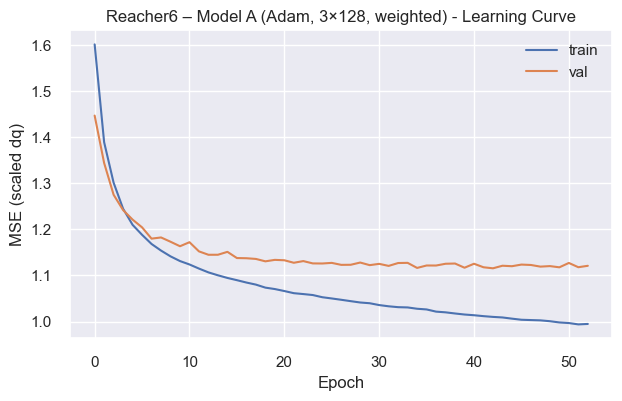

559/559 [==============================] - 1s 1ms/step
=== Reacher6 – Model A (Adam, weighted) – Val ===
MSE: 1.97535e-03
MAE: 3.42388e-02
R2 : 0.4396
139/139 [==============================] - 0s 1ms/step

=== Reacher6 – Model A (Adam, weighted) – Test ===
MSE: 2.09553e-03
MAE: 3.54007e-02
R2 : 0.4125

Per-joint metrics – Reacher6, Model A (Adam, weighted)


joint       mse       mae        r2
0   dq1  0.000973  0.021805  0.741609
1   dq2  0.001499  0.030457  0.547239
2   dq3  0.002376  0.039045  0.332728
3   dq4  0.002418  0.039049  0.296821
4   dq5  0.002593  0.040451  0.292261
5   dq6  0.002714  0.041598  0.264215

In [169]:
plt.figure(figsize=(7,4))
plt.plot(history_6a.history["loss"], label="train")
plt.plot(history_6a.history["val_loss"], label="val")
plt.title("Reacher6 – Model A (Adam, 3×128, weighted) - Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled dq)")
plt.legend()
plt.show()


y_val_pred_6a_s = mlp6_adam.predict(X_val_6_s)
y_val_pred_6a   = y_scaler_6.inverse_transform(y_val_pred_6a_s)

mse_val_6a = mean_squared_error(y_val_6, y_val_pred_6a)
mae_val_6a = mean_absolute_error(y_val_6, y_val_pred_6a)
r2_val_6a  = r2_score(y_val_6, y_val_pred_6a)

print("=== Reacher6 – Model A (Adam, weighted) – Val ===")
print(f"MSE: {mse_val_6a:.5e}")
print(f"MAE: {mae_val_6a:.5e}")
print(f"R2 : {r2_val_6a:.4f}")

y_test_pred_6a_s = mlp6_adam.predict(X_test_6_s)
y_test_pred_6a   = y_scaler_6.inverse_transform(y_test_pred_6a_s)

mse_test_6a = mean_squared_error(y_test_6, y_test_pred_6a)
mae_test_6a = mean_absolute_error(y_test_6, y_test_pred_6a)
r2_test_6a  = r2_score(y_test_6, y_test_pred_6a)

print("\n=== Reacher6 – Model A (Adam, weighted) – Test ===")
print(f"MSE: {mse_test_6a:.5e}")
print(f"MAE: {mae_test_6a:.5e}")
print(f"R2 : {r2_test_6a:.4f}")


joint_names_6 = ["dq1", "dq2", "dq3", "dq4", "dq5", "dq6"]

per_joint_6a = per_joint_metrics(y_test_6, y_test_pred_6a, joint_names_6)
print("\nPer-joint metrics – Reacher6, Model A (Adam, weighted)")
display(per_joint_6a)


In [170]:
# Model B: SGD+momentum + dropout (3×128)

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

mlp6_sgd_do = models.Sequential([
    layers.Input(shape=(X_train_6_s.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(6, activation="linear"),
])

sgd_opt_6 = tf.keras.optimizers.SGD(
    learning_rate=5e-3,
    momentum=0.9,
    nesterov=True
)

mlp6_sgd_do.compile(
    optimizer=sgd_opt_6,
    loss="mse",
    metrics=["mae"],
    weighted_metrics=[]
)

early_stop_6b = EarlyStopping(
    monitor="val_loss",
    patience=15,
    restore_best_weights=True
)

history_6b = mlp6_sgd_do.fit(
    X_train_6_s, y_train_6_s,
    sample_weight=w_train_6,
    validation_data=(X_val_6_s, y_val_6_s, w_val_6),
    epochs=250,
    batch_size=256,
    callbacks=[early_stop_6b],
    verbose=2
)


Epoch 1/250
280/280 - 5s - loss: 2.0553 - mae: 0.7873 - val_loss: 1.8342 - val_mae: 0.7459 - 5s/epoch - 19ms/step
Epoch 2/250
280/280 - 1s - loss: 1.8119 - mae: 0.7474 - val_loss: 1.6096 - val_mae: 0.7050 - 1s/epoch - 4ms/step
Epoch 3/250
280/280 - 2s - loss: 1.7002 - mae: 0.7271 - val_loss: 1.5627 - val_mae: 0.6958 - 2s/epoch - 5ms/step
Epoch 4/250
280/280 - 2s - loss: 1.6568 - mae: 0.7181 - val_loss: 1.5382 - val_mae: 0.6902 - 2s/epoch - 6ms/step
Epoch 5/250
280/280 - 2s - loss: 1.6304 - mae: 0.7122 - val_loss: 1.5197 - val_mae: 0.6862 - 2s/epoch - 6ms/step
Epoch 6/250
280/280 - 1s - loss: 1.6096 - mae: 0.7080 - val_loss: 1.5038 - val_mae: 0.6827 - 1s/epoch - 5ms/step
Epoch 7/250
280/280 - 2s - loss: 1.5921 - mae: 0.7041 - val_loss: 1.4912 - val_mae: 0.6793 - 2s/epoch - 6ms/step
Epoch 8/250
280/280 - 2s - loss: 1.5783 - mae: 0.7006 - val_loss: 1.4764 - val_mae: 0.6757 - 2s/epoch - 6ms/step
Epoch 9/250
280/280 - 1s - loss: 1.5646 - mae: 0.6978 - val_loss: 1.4642 - val_mae: 0.6729 - 1s

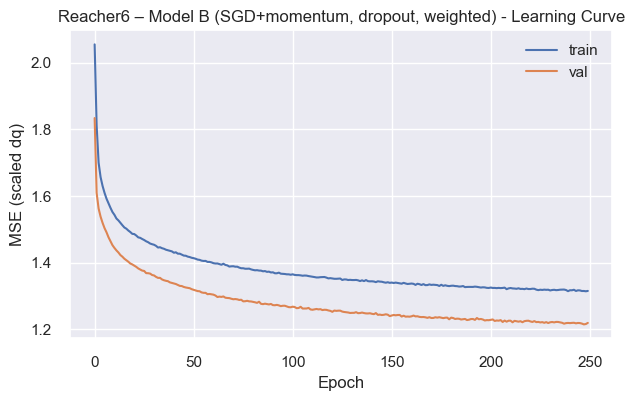

559/559 [==============================] - 1s 1ms/step
=== Reacher6 – Model B (SGD+momentum, dropout) – Val ===
MSE: 2.14878e-03
MAE: 3.63764e-02
R2 : 0.3905
139/139 [==============================] - 0s 1ms/step

=== Reacher6 – Model B (SGD+momentum, dropout) – Test ===
MSE: 2.20040e-03
MAE: 3.69413e-02
R2 : 0.3832

Per-joint metrics – Reacher6, Model B (SGD+momentum, dropout)


joint       mse       mae        r2
0   dq1  0.001117  0.024169  0.703472
1   dq2  0.001617  0.032162  0.511556
2   dq3  0.002410  0.039740  0.323334
3   dq4  0.002498  0.040001  0.273724
4   dq5  0.002713  0.042026  0.259512
5   dq6  0.002848  0.043550  0.227737

In [171]:
plt.figure(figsize=(7,4))
plt.plot(history_6b.history["loss"], label="train")
plt.plot(history_6b.history["val_loss"], label="val")
plt.title("Reacher6 – Model B (SGD+momentum, dropout, weighted) - Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE (scaled dq)")
plt.legend()
plt.show()

y_val_pred_6b_s = mlp6_sgd_do.predict(X_val_6_s)
y_val_pred_6b   = y_scaler_6.inverse_transform(y_val_pred_6b_s)

mse_val_6b = mean_squared_error(y_val_6, y_val_pred_6b)
mae_val_6b = mean_absolute_error(y_val_6, y_val_pred_6b)
r2_val_6b  = r2_score(y_val_6, y_val_pred_6b)

print("=== Reacher6 – Model B (SGD+momentum, dropout) – Val ===")
print(f"MSE: {mse_val_6b:.5e}")
print(f"MAE: {mae_val_6b:.5e}")
print(f"R2 : {r2_val_6b:.4f}")

y_test_pred_6b_s = mlp6_sgd_do.predict(X_test_6_s)
y_test_pred_6b   = y_scaler_6.inverse_transform(y_test_pred_6b_s)

mse_test_6b = mean_squared_error(y_test_6, y_test_pred_6b)
mae_test_6b = mean_absolute_error(y_test_6, y_test_pred_6b)
r2_test_6b  = r2_score(y_test_6, y_test_pred_6b)

print("\n=== Reacher6 – Model B (SGD+momentum, dropout) – Test ===")
print(f"MSE: {mse_test_6b:.5e}")
print(f"MAE: {mae_test_6b:.5e}")
print(f"R2 : {r2_test_6b:.4f}")

per_joint_6b = per_joint_metrics(y_test_6, y_test_pred_6b, joint_names_6)
print("\nPer-joint metrics – Reacher6, Model B (SGD+momentum, dropout)")
display(per_joint_6b)

  - [10.1 Reacher6 – conclusions](#101-reacher6--conclusions)

Reacher6 is another step up in difficulty. The best model now reaches **~0.41 R²**, which is clearly lower than Reacher4 (~0.67) and Reacher3 (~0.69). With 6 DoF, the inverse mapping becomes more nonlinear and harder to approximate with a simple feed-forward MLP.

As before, **Model A (Adam + weighting)** performs better than **Model B (SGD + dropout)**. Adam gives slightly higher R², lower errors, and more stable learning. The SGD+dropout model underfits even more strongly here.

Per-joint metrics show a familiar pattern but amplified:  
- **dq1 and dq2** remain the easiest (R² ≈ 0.55–0.74)  
- Performance drops steadily for **dq3–dq6** (R² ≈ 0.22–0.33)

Overall, Reacher6 confirms the trend: **the more distal the joint and the higher the DoF, the harder the prediction task becomes**, and the weighted Adam model continues to be the most reliable choice among the tested architectures.
